<a href="https://colab.research.google.com/github/Nataliely/QCES/blob/main/project4_storms_ny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project4_storms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Storms
In this project, we will use Dedalus to solve the 2-layer quasi-geostrophic equations to model the development of atmospheric storm systems.

The two-layer quasi-geostrophic (QG) equations describe the motion of two vertically-stacked shallow layers of fluid in the limit where the Rossby number, $Ro=U/fL$ is small, where $U$ is a characteristic velocity scale, $L$ is a characteristic horizontal lengthscale, and $f$ is the Coriolis parameter. Here, we will use `1` to refer to quantitites in the upper layer and `2` to refer to quantities in the lower layer.

The fluid in the upper layer is lighter than the fluid in the lower layer (such that $\rho_1<\rho_2$). When the interface separating the upper and lower layers isn't flat, the varying thicknesses of the upper and lower layers implies that there are horizontal gradients in the hydrostatic pressure. When the Rossby number is small, $Ro\ll 1$, the flow will tend to be close to geostrophic balance a velocity difference between the upper and lower layer that balances the horizontal pressure gradients.

Student tasks are in [Section 1.5](#section1pt5), [Section 2.3](#section2pt3), and [Section 3.1](#section3pt1).

Rossby number: ratio of inertial force to Coriolis force, when Ro << 1, Coriolis force dominates and the flow tends to be in geostrophic balance - pressure gradient force is balanced by the Coriolis force

Quasi-geostrophic (QG) equations are derived under this assumption of small Ro, making them suitable for large-scale atmospheric and oceanic flows where the Earth's rotation plays a crucial role.

Interface Displacement and Pressure Gradients:

* When the interface between the layers is not flat, it implies varying thicknesses of the upper and lower layers.
* This variation in layer thickness leads to horizontal gradients in the hydrostatic pressure.
* These pressure gradients drive the flow, but due to the small Rossby number, the flow quickly adjusts to be close to geostrophic balance.

Geostrophic Balance and Velocity Differences:

* In geostrophic balance, the horizontal pressure gradient force is balanced by the Coriolis force.
* This balance results in a velocity difference between the upper and lower layers. The velocity in the upper layer is typically in the opposite direction to the velocity in the lower layer.
* This velocity difference is crucial for the development of baroclinic instability, which is a key mechanism for the formation of storms in the atmosphere and eddies in the ocean.

In [ ]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1. Two-layer quasi-geostrophic equations in a periodic box

In this section we will solve a non-dimensional version of the two-layer QG equations in Cartesian coordinates. Let $+x$ denote the eastwards direction and $+y$ denote the northwards direction. We start with a flow in geostrophic balance where the velocity is constant in each layer. Let $U \hat{\mathbf{x}}$ denote the velocity in the top layer and $-U \hat{\mathbf{x}}$ denote the velocity in the bottom layer. Geostrophic balance then implies that the interface has a constant, non-zero slope. We will invoke the so-called "beta-plane" approximation and make the Coriolis parameter a linear function of $y$.

In this section we solve for the departures to the background state described above. We let $q_1$ and $q_2$ denote the perturbation QG potential vorticity and $\psi_1$ and $\psi_2$ denote the perturbation streamfunction. Although the background state is not periodic, we apply periodic boundary conditions in $x$ and $y$ to the perturbation quantities. This has the effect of maintaining the north/south potential vorticity gradient associated with the background state.

### 1.1 Governing equations

The script below solves the following equations:

$$ \partial_t(q_1) + U \partial_x(q_1) + \frac{2U}{R_{d1}^2}\partial_x(\psi_1)-\nu \nabla^2 q_1 = - J(\psi_1, q_1), $$

$$ \partial_t(q_2) - U \partial_x(q_2) - \frac{2U}{R_{d2}^2}\partial_x(\psi_2)-\nu \nabla^2 q_2 = - J(\psi_2, q_2), $$

where $R_{d1,2}=\sqrt{g'H_{1,2}}/f_0$ is the internal deformation radius in each layer, $g'=(\rho_2-\rho_1)/\rho_0$ is the reduced gravity, $\rho_0$ is a reference density, $J(a,b)=\partial_x(a)\partial_y(b) - \partial_y(a)\partial_x(b)$ is the Jacobian operator and $\nu$ is a viscosity which is added to keep the model stable.

In addition to the equations above, two other equations relate the perturbation potential vorticity and streamfunctions:

$$q_1=\nabla^2\psi_1 - \frac{\psi_1-\psi_2}{R_{d1}^2}, $$
$$q_2=\nabla^2\psi_2 + \frac{\psi_1-\psi_2}{R_{d2}^2}. $$

### 1.2 Tau method

The equations above are invariant to a constant added to $\psi_1-\psi_2$. Therefore, there are infinitely many solutions to the above equations and the coefficient matrix associated with the discretized equations will be singular. To avoid this, we can add an extra equation to the system to set this constant offset. Here, we do this by including the following equation:

$$ \int\int \psi_1 dxdy = 0 $$

which in effect ensures that the spatial mean of $\psi_1$ is zero. The problem now is that we have five equations for four unknowns. One fix is to include another unknown in our system. We will include a constant called $\tau_{\psi1}$ and we will add it to the equation relating the upper layer QG potential voricity and streamfunction which then becomes:

$$q_1=\nabla^2\psi_1 - \frac{\psi_1-\psi_2}{R_{d1}^2} + \tau_{\psi1}. $$

Since adding a constant to the potential vorticity and streamfunction doesn't have any impact on the dynamics of the system, adding $\tau_{\psi1}$ here won't cause any problems and we now have a fully constained set of equations.


Beta-Plane Approximation:

The beta-plane approximation is invoked, which assumes that the Coriolis parameter (f) varies linearly with latitude (y). This is expressed as f = f0 + βy, where f0 is the Coriolis parameter at a reference latitude and β is the meridional gradient of the Coriolis parameter.

The first two equations you provided are the governing equations for the evolution of the perturbation potential vorticity (q1 and q2) in each layer

* ∂𝑡(𝑞1), ∂𝑡(𝑞2): These terms represent the time rate of change of the potential vorticity in each layer.
* U∂𝑥(𝑞1), -U∂𝑥(𝑞2): These terms represent the advection of potential vorticity by the background flow (U) in the x-direction. Note the opposite signs due to the opposing background flow directions in each layer.
* (2U/𝑅𝑑1^2)∂𝑥(𝜓1), -(2U/𝑅𝑑2^2)∂𝑥(𝜓2): These terms are related to the stretching and compression of the fluid columns due to variations in layer thickness. They involve the internal deformation radius (Rd) of each layer.
* 𝜈∇^2𝑞1, 𝜈∇^2𝑞2: These terms represent the diffusion of potential vorticity due to viscosity (𝜈). They help stabilize the model by damping out small-scale features.
* -𝐽(𝜓1, 𝑞1), -𝐽(𝜓2, 𝑞2): These terms represent the nonlinear advection of potential vorticity by the flow itself. The Jacobian operator (J) captures the interaction between the streamfunction (ψ) and potential vorticity (q).

The next two equations relate the perturbation potential vorticity (q1, q2) to the perturbation streamfunction (ψ1, ψ2)

* ∇^2𝜓1, ∇^2𝜓2: These terms represent the Laplacian of the streamfunction, which is related to the relative vorticity of the flow.
* -(𝜓1 - 𝜓2)/𝑅𝑑1^2, (𝜓1 - 𝜓2)/𝑅𝑑2^2: These terms account for the effect of interface displacement on the potential vorticity. They involve the difference in streamfunctions between the layers and the internal deformation radius (Rd).

The Problem of Invariance:

* The two-layer QG equations have a property called invariance to a constant offset in the streamfunction difference (ψ1 - ψ2). This means that if you add a constant value to both ψ1 and ψ2, the equations remain unchanged.
* This invariance can lead to a singular coefficient matrix when the equations are discretized for numerical solution. A singular matrix means there are infinitely many solutions, making it impossible to find a unique solution.

Why Tau Doesn't Affect Dynamics:

* Adding a constant to the potential vorticity (q) and streamfunction (ψ) doesn't change the dynamics of the system. This is because the QG equations are primarily concerned with the gradients and derivatives of these quantities, not their absolute values.
* Therefore, introducing τψ1 doesn't alter the physical behavior of the model but helps ensure a well-defined and solvable numerical system.

### 1.3 Dedalus script

The script below solves the 2-layer QG equations given above with non-dimensional parameters. Note that the velocity gets faster as the simulation progresses. If you find that the code blows up (returns NaNs and a white screen), try reducing the timestep.

1. Velocity Increase and Instability:

* The two-layer QG equations, especially in the configuration used in your code, can exhibit baroclinic instability. This instability arises due to the interaction between the background flow, the density difference between layers, and the Earth's rotation.
* As the instability develops, energy is transferred from the background flow to the perturbations (storms or eddies), leading to an increase in their amplitude and velocity.
* This velocity increase can become quite rapid, especially in the nonlinear stages of the instability.

2. Timestep and Numerical Stability:

* Numerical solutions of the QG equations, like the one implemented in your code, are subject to numerical stability constraints.
* One crucial factor is the timestep used in the simulation. If the timestep is too large, the numerical scheme may not be able to accurately capture the rapidly evolving flow, leading to instability.
* This instability can manifest as the solution "blowing up," meaning it produces unrealistic values (like NaNs) and may crash the simulation.

3. Reducing the Timestep:

* To mitigate the risk of the simulation blowing up, you can reduce the timestep.
* A smaller timestep allows the numerical scheme to take more frequent and smaller steps in time, better capturing the flow's evolution and maintaining stability.
* The code snippet you provided already suggests this as a potential solution if you encounter issues with NaNs or a white screen.

4. Finding the Right Balance:

* There's a trade-off between accuracy and computational cost when choosing the timestep. A smaller timestep increases accuracy but also requires more computational time.
* You'll need to find a timestep that is small enough to maintain stability but not so small that it makes the simulation excessively slow.
* Experimentation and monitoring the simulation's behavior are key to finding the optimal timestep for your specific setup.

In [ ]:
# # Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 64 # Number of gridpoints in x
Ny = 64 # Number of gridpoints in y
Lx = 100 # Domain size in x
Ly = 100 # Domain size in y
Rd1 = 3 # Deformation radius in layer 1
Rd2 = 3 # Deformation radius in layer 2
U = 1 # Background velocity in layer 1

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu = 0.2

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U,-1*U)/100 # This is just an estimate based on the background velocity
stop_sim_time = 70

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Set the initial conditions
q1.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
q2.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U*dx(q1) + (2*U/Rd1**2.0)*dx(psi1) - nu*lap(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) - U*dx(q2) - (2*U/Rd2**2.0)*dx(psi2) - nu*lap(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")

problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK443)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];
t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 2s, Rate: 1.7e+01/s


2024-11-26 14:33:09,129 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 2s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 2s, Rate: 1.7e+01/s


2024-11-26 14:33:09,311 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 2s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 1.9e+01/s


2024-11-26 14:33:09,488 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 1.9e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 1s, Remaining: 1s, Rate: 2.2e+01/s


2024-11-26 14:33:09,621 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 1s, Remaining: 1s, Rate: 2.2e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.4e+01/s


2024-11-26 14:33:09,743 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.4e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 2.5e+01/s


2024-11-26 14:33:09,866 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 2.6e+01/s


2024-11-26 14:33:09,989 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 2.7e+01/s


2024-11-26 14:33:10,113 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.7e+01/s


2024-11-26 14:33:10,238 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.7e+01/s


INFO:__main__:Starting main loop


2024-11-26 14:33:10,248 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e-03, dt=7.812500e-03


2024-11-26 14:33:10,410 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e-03, dt=7.812500e-03


INFO:__main__:Iteration=11, Time=8.593750e-02, dt=7.812500e-03


2024-11-26 14:33:10,692 __main__ 0/1 INFO :: Iteration=11, Time=8.593750e-02, dt=7.812500e-03


INFO:__main__:Iteration=21, Time=1.640625e-01, dt=7.812500e-03


2024-11-26 14:33:10,956 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e-01, dt=7.812500e-03


INFO:__main__:Iteration=31, Time=2.421875e-01, dt=7.812500e-03


2024-11-26 14:33:11,221 __main__ 0/1 INFO :: Iteration=31, Time=2.421875e-01, dt=7.812500e-03


INFO:__main__:Iteration=41, Time=3.203125e-01, dt=7.812500e-03


2024-11-26 14:33:11,514 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e-01, dt=7.812500e-03


INFO:__main__:Iteration=51, Time=3.984375e-01, dt=7.812500e-03


2024-11-26 14:33:11,793 __main__ 0/1 INFO :: Iteration=51, Time=3.984375e-01, dt=7.812500e-03


INFO:__main__:Iteration=61, Time=4.765625e-01, dt=7.812500e-03


2024-11-26 14:33:12,060 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e-01, dt=7.812500e-03


INFO:__main__:Iteration=71, Time=5.546875e-01, dt=7.812500e-03


2024-11-26 14:33:12,339 __main__ 0/1 INFO :: Iteration=71, Time=5.546875e-01, dt=7.812500e-03


INFO:__main__:Iteration=81, Time=6.328125e-01, dt=7.812500e-03


2024-11-26 14:33:12,625 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e-01, dt=7.812500e-03


INFO:__main__:Iteration=91, Time=7.109375e-01, dt=7.812500e-03


2024-11-26 14:33:12,896 __main__ 0/1 INFO :: Iteration=91, Time=7.109375e-01, dt=7.812500e-03


INFO:__main__:Iteration=101, Time=7.890625e-01, dt=7.812500e-03


2024-11-26 14:33:13,165 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e-01, dt=7.812500e-03


INFO:__main__:Iteration=111, Time=8.671875e-01, dt=7.812500e-03


2024-11-26 14:33:13,444 __main__ 0/1 INFO :: Iteration=111, Time=8.671875e-01, dt=7.812500e-03


INFO:__main__:Iteration=121, Time=9.453125e-01, dt=7.812500e-03


2024-11-26 14:33:13,726 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e-01, dt=7.812500e-03


INFO:__main__:Iteration=131, Time=1.023438e+00, dt=7.812500e-03


2024-11-26 14:33:14,146 __main__ 0/1 INFO :: Iteration=131, Time=1.023438e+00, dt=7.812500e-03


INFO:__main__:Iteration=141, Time=1.101562e+00, dt=7.812500e-03


2024-11-26 14:33:14,675 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+00, dt=7.812500e-03


INFO:__main__:Iteration=151, Time=1.179688e+00, dt=7.812500e-03


2024-11-26 14:33:15,399 __main__ 0/1 INFO :: Iteration=151, Time=1.179688e+00, dt=7.812500e-03


INFO:__main__:Iteration=161, Time=1.257812e+00, dt=7.812500e-03


2024-11-26 14:33:16,143 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+00, dt=7.812500e-03


INFO:__main__:Iteration=171, Time=1.335938e+00, dt=7.812500e-03


2024-11-26 14:33:16,883 __main__ 0/1 INFO :: Iteration=171, Time=1.335938e+00, dt=7.812500e-03


INFO:__main__:Iteration=181, Time=1.414062e+00, dt=7.812500e-03


2024-11-26 14:33:17,787 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+00, dt=7.812500e-03


INFO:__main__:Iteration=191, Time=1.492188e+00, dt=7.812500e-03


2024-11-26 14:33:19,298 __main__ 0/1 INFO :: Iteration=191, Time=1.492188e+00, dt=7.812500e-03


INFO:__main__:Iteration=201, Time=1.570312e+00, dt=7.812500e-03


2024-11-26 14:33:19,989 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+00, dt=7.812500e-03


INFO:__main__:Iteration=211, Time=1.648438e+00, dt=7.812500e-03


2024-11-26 14:33:20,435 __main__ 0/1 INFO :: Iteration=211, Time=1.648438e+00, dt=7.812500e-03


INFO:__main__:Iteration=221, Time=1.726562e+00, dt=7.812500e-03


2024-11-26 14:33:20,878 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+00, dt=7.812500e-03


INFO:__main__:Iteration=231, Time=1.804688e+00, dt=7.812500e-03


2024-11-26 14:33:21,195 __main__ 0/1 INFO :: Iteration=231, Time=1.804688e+00, dt=7.812500e-03


INFO:__main__:Iteration=241, Time=1.882812e+00, dt=7.812500e-03


2024-11-26 14:33:21,470 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+00, dt=7.812500e-03


INFO:__main__:Iteration=251, Time=1.960938e+00, dt=7.812500e-03


2024-11-26 14:33:21,748 __main__ 0/1 INFO :: Iteration=251, Time=1.960938e+00, dt=7.812500e-03


INFO:__main__:Iteration=261, Time=2.039062e+00, dt=7.812500e-03


2024-11-26 14:33:22,019 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+00, dt=7.812500e-03


INFO:__main__:Iteration=271, Time=2.117188e+00, dt=7.812500e-03


2024-11-26 14:33:22,299 __main__ 0/1 INFO :: Iteration=271, Time=2.117188e+00, dt=7.812500e-03


INFO:__main__:Iteration=281, Time=2.195312e+00, dt=7.812500e-03


2024-11-26 14:33:22,588 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+00, dt=7.812500e-03


INFO:__main__:Iteration=291, Time=2.273438e+00, dt=7.812500e-03


2024-11-26 14:33:22,856 __main__ 0/1 INFO :: Iteration=291, Time=2.273438e+00, dt=7.812500e-03


INFO:__main__:Iteration=301, Time=2.351562e+00, dt=7.812500e-03


2024-11-26 14:33:23,148 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+00, dt=7.812500e-03


INFO:__main__:Iteration=311, Time=2.429688e+00, dt=7.812500e-03


2024-11-26 14:33:23,434 __main__ 0/1 INFO :: Iteration=311, Time=2.429688e+00, dt=7.812500e-03


INFO:__main__:Iteration=321, Time=2.507812e+00, dt=7.812500e-03


2024-11-26 14:33:23,707 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+00, dt=7.812500e-03


INFO:__main__:Iteration=331, Time=2.585938e+00, dt=7.812500e-03


2024-11-26 14:33:23,977 __main__ 0/1 INFO :: Iteration=331, Time=2.585938e+00, dt=7.812500e-03


INFO:__main__:Iteration=341, Time=2.664062e+00, dt=7.812500e-03


2024-11-26 14:33:24,267 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+00, dt=7.812500e-03


INFO:__main__:Iteration=351, Time=2.742188e+00, dt=7.812500e-03


2024-11-26 14:33:24,553 __main__ 0/1 INFO :: Iteration=351, Time=2.742188e+00, dt=7.812500e-03


INFO:__main__:Iteration=361, Time=2.820312e+00, dt=7.812500e-03


2024-11-26 14:33:24,821 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+00, dt=7.812500e-03


INFO:__main__:Iteration=371, Time=2.898438e+00, dt=7.812500e-03


2024-11-26 14:33:25,089 __main__ 0/1 INFO :: Iteration=371, Time=2.898438e+00, dt=7.812500e-03


INFO:__main__:Iteration=381, Time=2.976562e+00, dt=7.812500e-03


2024-11-26 14:33:25,373 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+00, dt=7.812500e-03


INFO:__main__:Iteration=391, Time=3.054688e+00, dt=7.812500e-03


2024-11-26 14:33:25,649 __main__ 0/1 INFO :: Iteration=391, Time=3.054688e+00, dt=7.812500e-03


INFO:__main__:Iteration=401, Time=3.132812e+00, dt=7.812500e-03


2024-11-26 14:33:25,918 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+00, dt=7.812500e-03


INFO:__main__:Iteration=411, Time=3.210938e+00, dt=7.812500e-03


2024-11-26 14:33:26,190 __main__ 0/1 INFO :: Iteration=411, Time=3.210938e+00, dt=7.812500e-03


INFO:__main__:Iteration=421, Time=3.289062e+00, dt=7.812500e-03


2024-11-26 14:33:26,475 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+00, dt=7.812500e-03


INFO:__main__:Iteration=431, Time=3.367188e+00, dt=7.812500e-03


2024-11-26 14:33:26,775 __main__ 0/1 INFO :: Iteration=431, Time=3.367188e+00, dt=7.812500e-03


INFO:__main__:Iteration=441, Time=3.445312e+00, dt=7.812500e-03


2024-11-26 14:33:27,037 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+00, dt=7.812500e-03


INFO:__main__:Iteration=451, Time=3.523438e+00, dt=7.812500e-03


2024-11-26 14:33:27,324 __main__ 0/1 INFO :: Iteration=451, Time=3.523438e+00, dt=7.812500e-03


INFO:__main__:Iteration=461, Time=3.601562e+00, dt=7.812500e-03


2024-11-26 14:33:27,597 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+00, dt=7.812500e-03


INFO:__main__:Iteration=471, Time=3.679688e+00, dt=7.812500e-03


2024-11-26 14:33:27,868 __main__ 0/1 INFO :: Iteration=471, Time=3.679688e+00, dt=7.812500e-03


INFO:__main__:Iteration=481, Time=3.757812e+00, dt=7.812500e-03


2024-11-26 14:33:28,149 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+00, dt=7.812500e-03


INFO:__main__:Iteration=491, Time=3.835938e+00, dt=7.812500e-03


2024-11-26 14:33:28,450 __main__ 0/1 INFO :: Iteration=491, Time=3.835938e+00, dt=7.812500e-03


INFO:__main__:Iteration=501, Time=3.914062e+00, dt=7.812500e-03


2024-11-26 14:33:28,715 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+00, dt=7.812500e-03


INFO:__main__:Iteration=511, Time=3.992188e+00, dt=7.812500e-03


2024-11-26 14:33:28,969 __main__ 0/1 INFO :: Iteration=511, Time=3.992188e+00, dt=7.812500e-03


INFO:__main__:Iteration=521, Time=4.070312e+00, dt=7.812500e-03


2024-11-26 14:33:29,238 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+00, dt=7.812500e-03


INFO:__main__:Iteration=531, Time=4.148438e+00, dt=7.812500e-03


2024-11-26 14:33:29,530 __main__ 0/1 INFO :: Iteration=531, Time=4.148438e+00, dt=7.812500e-03


INFO:__main__:Iteration=541, Time=4.226562e+00, dt=7.812500e-03


2024-11-26 14:33:29,801 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+00, dt=7.812500e-03


INFO:__main__:Iteration=551, Time=4.304688e+00, dt=7.812500e-03


2024-11-26 14:33:30,063 __main__ 0/1 INFO :: Iteration=551, Time=4.304688e+00, dt=7.812500e-03


INFO:__main__:Iteration=561, Time=4.382812e+00, dt=7.812500e-03


2024-11-26 14:33:30,356 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+00, dt=7.812500e-03


INFO:__main__:Iteration=571, Time=4.460938e+00, dt=7.812500e-03


2024-11-26 14:33:30,631 __main__ 0/1 INFO :: Iteration=571, Time=4.460938e+00, dt=7.812500e-03


INFO:__main__:Iteration=581, Time=4.539062e+00, dt=7.812500e-03


2024-11-26 14:33:30,889 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+00, dt=7.812500e-03


INFO:__main__:Iteration=591, Time=4.617188e+00, dt=7.812500e-03


2024-11-26 14:33:31,275 __main__ 0/1 INFO :: Iteration=591, Time=4.617188e+00, dt=7.812500e-03


INFO:__main__:Iteration=601, Time=4.695312e+00, dt=7.812500e-03


2024-11-26 14:33:31,726 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+00, dt=7.812500e-03


INFO:__main__:Iteration=611, Time=4.773438e+00, dt=7.812500e-03


2024-11-26 14:33:32,128 __main__ 0/1 INFO :: Iteration=611, Time=4.773438e+00, dt=7.812500e-03


INFO:__main__:Iteration=621, Time=4.851562e+00, dt=7.812500e-03


2024-11-26 14:33:32,549 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+00, dt=7.812500e-03


INFO:__main__:Iteration=631, Time=4.929688e+00, dt=7.812500e-03


2024-11-26 14:33:32,969 __main__ 0/1 INFO :: Iteration=631, Time=4.929688e+00, dt=7.812500e-03


INFO:__main__:Iteration=641, Time=5.007812e+00, dt=7.812500e-03


2024-11-26 14:33:33,390 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+00, dt=7.812500e-03


INFO:__main__:Iteration=651, Time=5.085938e+00, dt=7.812500e-03


2024-11-26 14:33:33,833 __main__ 0/1 INFO :: Iteration=651, Time=5.085938e+00, dt=7.812500e-03


INFO:__main__:Iteration=661, Time=5.164062e+00, dt=7.812500e-03


2024-11-26 14:33:34,277 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+00, dt=7.812500e-03


INFO:__main__:Iteration=671, Time=5.242188e+00, dt=7.812500e-03


2024-11-26 14:33:34,662 __main__ 0/1 INFO :: Iteration=671, Time=5.242188e+00, dt=7.812500e-03


INFO:__main__:Iteration=681, Time=5.320312e+00, dt=7.812500e-03


2024-11-26 14:33:34,928 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+00, dt=7.812500e-03


INFO:__main__:Iteration=691, Time=5.398438e+00, dt=7.812500e-03


2024-11-26 14:33:35,203 __main__ 0/1 INFO :: Iteration=691, Time=5.398438e+00, dt=7.812500e-03


INFO:__main__:Iteration=701, Time=5.476562e+00, dt=7.812500e-03


2024-11-26 14:33:35,481 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+00, dt=7.812500e-03


INFO:__main__:Iteration=711, Time=5.554688e+00, dt=7.812500e-03


2024-11-26 14:33:35,765 __main__ 0/1 INFO :: Iteration=711, Time=5.554688e+00, dt=7.812500e-03


INFO:__main__:Iteration=721, Time=5.632812e+00, dt=7.812500e-03


2024-11-26 14:33:36,026 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+00, dt=7.812500e-03


INFO:__main__:Iteration=731, Time=5.710938e+00, dt=7.812500e-03


2024-11-26 14:33:36,302 __main__ 0/1 INFO :: Iteration=731, Time=5.710938e+00, dt=7.812500e-03


INFO:__main__:Iteration=741, Time=5.789062e+00, dt=7.812500e-03


2024-11-26 14:33:36,588 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+00, dt=7.812500e-03


INFO:__main__:Iteration=751, Time=5.867188e+00, dt=7.812500e-03


2024-11-26 14:33:36,871 __main__ 0/1 INFO :: Iteration=751, Time=5.867188e+00, dt=7.812500e-03


INFO:__main__:Iteration=761, Time=5.945312e+00, dt=7.812500e-03


2024-11-26 14:33:37,135 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+00, dt=7.812500e-03


INFO:__main__:Iteration=771, Time=6.023438e+00, dt=7.812500e-03


2024-11-26 14:33:37,406 __main__ 0/1 INFO :: Iteration=771, Time=6.023438e+00, dt=7.812500e-03


INFO:__main__:Iteration=781, Time=6.101562e+00, dt=7.812500e-03


2024-11-26 14:33:37,698 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+00, dt=7.812500e-03


INFO:__main__:Iteration=791, Time=6.179688e+00, dt=7.812500e-03


2024-11-26 14:33:37,968 __main__ 0/1 INFO :: Iteration=791, Time=6.179688e+00, dt=7.812500e-03


INFO:__main__:Iteration=801, Time=6.257812e+00, dt=7.812500e-03


2024-11-26 14:33:38,237 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+00, dt=7.812500e-03


INFO:__main__:Iteration=811, Time=6.335938e+00, dt=7.812500e-03


2024-11-26 14:33:38,522 __main__ 0/1 INFO :: Iteration=811, Time=6.335938e+00, dt=7.812500e-03


INFO:__main__:Iteration=821, Time=6.414062e+00, dt=7.812500e-03


2024-11-26 14:33:38,805 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+00, dt=7.812500e-03


INFO:__main__:Iteration=831, Time=6.492188e+00, dt=7.812500e-03


2024-11-26 14:33:39,072 __main__ 0/1 INFO :: Iteration=831, Time=6.492188e+00, dt=7.812500e-03


INFO:__main__:Iteration=841, Time=6.570312e+00, dt=7.812500e-03


2024-11-26 14:33:39,356 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+00, dt=7.812500e-03


INFO:__main__:Iteration=851, Time=6.648438e+00, dt=7.812500e-03


2024-11-26 14:33:39,627 __main__ 0/1 INFO :: Iteration=851, Time=6.648438e+00, dt=7.812500e-03


INFO:__main__:Iteration=861, Time=6.726562e+00, dt=7.812500e-03


2024-11-26 14:33:39,909 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+00, dt=7.812500e-03


INFO:__main__:Iteration=871, Time=6.804688e+00, dt=7.812500e-03


2024-11-26 14:33:40,174 __main__ 0/1 INFO :: Iteration=871, Time=6.804688e+00, dt=7.812500e-03


INFO:__main__:Iteration=881, Time=6.882812e+00, dt=7.812500e-03


2024-11-26 14:33:40,449 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+00, dt=7.812500e-03


INFO:__main__:Iteration=891, Time=6.960938e+00, dt=7.812500e-03


2024-11-26 14:33:40,725 __main__ 0/1 INFO :: Iteration=891, Time=6.960938e+00, dt=7.812500e-03


INFO:__main__:Iteration=901, Time=7.039062e+00, dt=7.812500e-03


2024-11-26 14:33:41,001 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+00, dt=7.812500e-03


INFO:__main__:Iteration=911, Time=7.117188e+00, dt=7.812500e-03


2024-11-26 14:33:41,271 __main__ 0/1 INFO :: Iteration=911, Time=7.117188e+00, dt=7.812500e-03


INFO:__main__:Iteration=921, Time=7.195312e+00, dt=7.812500e-03


2024-11-26 14:33:41,559 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+00, dt=7.812500e-03


INFO:__main__:Iteration=931, Time=7.273438e+00, dt=7.812500e-03


2024-11-26 14:33:41,846 __main__ 0/1 INFO :: Iteration=931, Time=7.273438e+00, dt=7.812500e-03


INFO:__main__:Iteration=941, Time=7.351562e+00, dt=7.812500e-03


2024-11-26 14:33:42,118 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+00, dt=7.812500e-03


INFO:__main__:Iteration=951, Time=7.429688e+00, dt=7.812500e-03


2024-11-26 14:33:42,398 __main__ 0/1 INFO :: Iteration=951, Time=7.429688e+00, dt=7.812500e-03


INFO:__main__:Iteration=961, Time=7.507812e+00, dt=7.812500e-03


2024-11-26 14:33:42,666 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+00, dt=7.812500e-03


INFO:__main__:Iteration=971, Time=7.585938e+00, dt=7.812500e-03


2024-11-26 14:33:42,950 __main__ 0/1 INFO :: Iteration=971, Time=7.585938e+00, dt=7.812500e-03


INFO:__main__:Iteration=981, Time=7.664062e+00, dt=7.812500e-03


2024-11-26 14:33:43,233 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+00, dt=7.812500e-03


INFO:__main__:Iteration=991, Time=7.742188e+00, dt=7.812500e-03


2024-11-26 14:33:43,521 __main__ 0/1 INFO :: Iteration=991, Time=7.742188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1001, Time=7.820312e+00, dt=7.812500e-03


2024-11-26 14:33:43,805 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1011, Time=7.898438e+00, dt=7.812500e-03


2024-11-26 14:33:44,088 __main__ 0/1 INFO :: Iteration=1011, Time=7.898438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1021, Time=7.976562e+00, dt=7.812500e-03


2024-11-26 14:33:44,380 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1031, Time=8.054688e+00, dt=7.812500e-03


2024-11-26 14:33:44,750 __main__ 0/1 INFO :: Iteration=1031, Time=8.054688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1041, Time=8.132812e+00, dt=7.812500e-03


2024-11-26 14:33:45,174 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+00, dt=7.812500e-03


INFO:__main__:Iteration=1051, Time=8.210938e+00, dt=7.812500e-03


2024-11-26 14:33:45,597 __main__ 0/1 INFO :: Iteration=1051, Time=8.210938e+00, dt=7.812500e-03


INFO:__main__:Iteration=1061, Time=8.289062e+00, dt=7.812500e-03


2024-11-26 14:33:46,006 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+00, dt=7.812500e-03


INFO:__main__:Iteration=1071, Time=8.367188e+00, dt=7.812500e-03


2024-11-26 14:33:46,442 __main__ 0/1 INFO :: Iteration=1071, Time=8.367188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1081, Time=8.445312e+00, dt=7.812500e-03


2024-11-26 14:33:46,876 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1091, Time=8.523438e+00, dt=7.812500e-03


2024-11-26 14:33:47,309 __main__ 0/1 INFO :: Iteration=1091, Time=8.523438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1101, Time=8.601562e+00, dt=7.812500e-03


2024-11-26 14:33:47,748 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1111, Time=8.679688e+00, dt=7.812500e-03


2024-11-26 14:33:48,184 __main__ 0/1 INFO :: Iteration=1111, Time=8.679688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1121, Time=8.757812e+00, dt=7.812500e-03


2024-11-26 14:33:48,467 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+00, dt=7.812500e-03


INFO:__main__:Iteration=1131, Time=8.835938e+00, dt=7.812500e-03


2024-11-26 14:33:48,739 __main__ 0/1 INFO :: Iteration=1131, Time=8.835938e+00, dt=7.812500e-03


INFO:__main__:Iteration=1141, Time=8.914062e+00, dt=7.812500e-03


2024-11-26 14:33:49,012 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+00, dt=7.812500e-03


INFO:__main__:Iteration=1151, Time=8.992188e+00, dt=7.812500e-03


2024-11-26 14:33:49,299 __main__ 0/1 INFO :: Iteration=1151, Time=8.992188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1161, Time=9.070312e+00, dt=7.812500e-03


2024-11-26 14:33:49,567 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1171, Time=9.148438e+00, dt=7.812500e-03


2024-11-26 14:33:49,839 __main__ 0/1 INFO :: Iteration=1171, Time=9.148438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1181, Time=9.226562e+00, dt=7.812500e-03


2024-11-26 14:33:50,103 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1191, Time=9.304688e+00, dt=7.812500e-03


2024-11-26 14:33:50,396 __main__ 0/1 INFO :: Iteration=1191, Time=9.304688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1201, Time=9.382812e+00, dt=7.812500e-03


2024-11-26 14:33:50,665 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+00, dt=7.812500e-03


INFO:__main__:Iteration=1211, Time=9.460938e+00, dt=7.812500e-03


2024-11-26 14:33:50,938 __main__ 0/1 INFO :: Iteration=1211, Time=9.460938e+00, dt=7.812500e-03


INFO:__main__:Iteration=1221, Time=9.539062e+00, dt=7.812500e-03


2024-11-26 14:33:51,226 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+00, dt=7.812500e-03


INFO:__main__:Iteration=1231, Time=9.617188e+00, dt=7.812500e-03


2024-11-26 14:33:51,509 __main__ 0/1 INFO :: Iteration=1231, Time=9.617188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1241, Time=9.695312e+00, dt=7.812500e-03


2024-11-26 14:33:51,781 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1251, Time=9.773438e+00, dt=7.812500e-03


2024-11-26 14:33:52,054 __main__ 0/1 INFO :: Iteration=1251, Time=9.773438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1261, Time=9.851562e+00, dt=7.812500e-03


2024-11-26 14:33:52,346 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1271, Time=9.929688e+00, dt=7.812500e-03


2024-11-26 14:33:52,611 __main__ 0/1 INFO :: Iteration=1271, Time=9.929688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1281, Time=1.000781e+01, dt=7.812500e-03


2024-11-26 14:33:52,875 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1291, Time=1.008594e+01, dt=7.812500e-03


2024-11-26 14:33:53,143 __main__ 0/1 INFO :: Iteration=1291, Time=1.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1301, Time=1.016406e+01, dt=7.812500e-03


2024-11-26 14:33:53,449 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1311, Time=1.024219e+01, dt=7.812500e-03


2024-11-26 14:33:53,727 __main__ 0/1 INFO :: Iteration=1311, Time=1.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1321, Time=1.032031e+01, dt=7.812500e-03


2024-11-26 14:33:53,993 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1331, Time=1.039844e+01, dt=7.812500e-03


2024-11-26 14:33:54,284 __main__ 0/1 INFO :: Iteration=1331, Time=1.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1341, Time=1.047656e+01, dt=7.812500e-03


2024-11-26 14:33:54,572 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1351, Time=1.055469e+01, dt=7.812500e-03


2024-11-26 14:33:54,849 __main__ 0/1 INFO :: Iteration=1351, Time=1.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1361, Time=1.063281e+01, dt=7.812500e-03


2024-11-26 14:33:55,126 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1371, Time=1.071094e+01, dt=7.812500e-03


2024-11-26 14:33:55,435 __main__ 0/1 INFO :: Iteration=1371, Time=1.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1381, Time=1.078906e+01, dt=7.812500e-03


2024-11-26 14:33:55,709 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1391, Time=1.086719e+01, dt=7.812500e-03


2024-11-26 14:33:55,980 __main__ 0/1 INFO :: Iteration=1391, Time=1.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1401, Time=1.094531e+01, dt=7.812500e-03


2024-11-26 14:33:56,255 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1411, Time=1.102344e+01, dt=7.812500e-03


2024-11-26 14:33:56,554 __main__ 0/1 INFO :: Iteration=1411, Time=1.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1421, Time=1.110156e+01, dt=7.812500e-03


2024-11-26 14:33:56,860 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1431, Time=1.117969e+01, dt=7.812500e-03


2024-11-26 14:33:57,139 __main__ 0/1 INFO :: Iteration=1431, Time=1.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1441, Time=1.125781e+01, dt=7.812500e-03


2024-11-26 14:33:57,436 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1451, Time=1.133594e+01, dt=7.812500e-03


2024-11-26 14:33:57,703 __main__ 0/1 INFO :: Iteration=1451, Time=1.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1461, Time=1.141406e+01, dt=7.812500e-03


2024-11-26 14:33:57,981 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1471, Time=1.149219e+01, dt=7.812500e-03


2024-11-26 14:33:58,313 __main__ 0/1 INFO :: Iteration=1471, Time=1.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1481, Time=1.157031e+01, dt=7.812500e-03


2024-11-26 14:33:58,764 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1491, Time=1.164844e+01, dt=7.812500e-03


2024-11-26 14:33:59,165 __main__ 0/1 INFO :: Iteration=1491, Time=1.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1501, Time=1.172656e+01, dt=7.812500e-03


2024-11-26 14:33:59,581 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1511, Time=1.180469e+01, dt=7.812500e-03


2024-11-26 14:33:59,980 __main__ 0/1 INFO :: Iteration=1511, Time=1.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1521, Time=1.188281e+01, dt=7.812500e-03


2024-11-26 14:34:00,414 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1531, Time=1.196094e+01, dt=7.812500e-03


2024-11-26 14:34:00,856 __main__ 0/1 INFO :: Iteration=1531, Time=1.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1541, Time=1.203906e+01, dt=7.812500e-03


2024-11-26 14:34:01,319 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1551, Time=1.211719e+01, dt=7.812500e-03


2024-11-26 14:34:01,686 __main__ 0/1 INFO :: Iteration=1551, Time=1.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1561, Time=1.219531e+01, dt=7.812500e-03


2024-11-26 14:34:01,960 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1571, Time=1.227344e+01, dt=7.812500e-03


2024-11-26 14:34:02,242 __main__ 0/1 INFO :: Iteration=1571, Time=1.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1581, Time=1.235156e+01, dt=7.812500e-03


2024-11-26 14:34:02,522 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1591, Time=1.242969e+01, dt=7.812500e-03


2024-11-26 14:34:02,812 __main__ 0/1 INFO :: Iteration=1591, Time=1.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1601, Time=1.250781e+01, dt=7.812500e-03


2024-11-26 14:34:03,088 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1611, Time=1.258594e+01, dt=7.812500e-03


2024-11-26 14:34:03,383 __main__ 0/1 INFO :: Iteration=1611, Time=1.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1621, Time=1.266406e+01, dt=7.812500e-03


2024-11-26 14:34:03,671 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1631, Time=1.274219e+01, dt=7.812500e-03


2024-11-26 14:34:03,955 __main__ 0/1 INFO :: Iteration=1631, Time=1.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1641, Time=1.282031e+01, dt=7.812500e-03


2024-11-26 14:34:04,231 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1651, Time=1.289844e+01, dt=7.812500e-03


2024-11-26 14:34:04,512 __main__ 0/1 INFO :: Iteration=1651, Time=1.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1661, Time=1.297656e+01, dt=7.812500e-03


2024-11-26 14:34:04,811 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1671, Time=1.305469e+01, dt=7.812500e-03


2024-11-26 14:34:05,092 __main__ 0/1 INFO :: Iteration=1671, Time=1.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1681, Time=1.313281e+01, dt=7.812500e-03


2024-11-26 14:34:05,387 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1691, Time=1.321094e+01, dt=7.812500e-03


2024-11-26 14:34:05,666 __main__ 0/1 INFO :: Iteration=1691, Time=1.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1701, Time=1.328906e+01, dt=7.812500e-03


2024-11-26 14:34:05,962 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1711, Time=1.336719e+01, dt=7.812500e-03


2024-11-26 14:34:06,243 __main__ 0/1 INFO :: Iteration=1711, Time=1.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1721, Time=1.344531e+01, dt=7.812500e-03


2024-11-26 14:34:06,539 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1731, Time=1.352344e+01, dt=7.812500e-03


2024-11-26 14:34:06,835 __main__ 0/1 INFO :: Iteration=1731, Time=1.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1741, Time=1.360156e+01, dt=7.812500e-03


2024-11-26 14:34:07,112 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1751, Time=1.367969e+01, dt=7.812500e-03


2024-11-26 14:34:07,394 __main__ 0/1 INFO :: Iteration=1751, Time=1.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1761, Time=1.375781e+01, dt=7.812500e-03


2024-11-26 14:34:07,659 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1771, Time=1.383594e+01, dt=7.812500e-03


2024-11-26 14:34:07,952 __main__ 0/1 INFO :: Iteration=1771, Time=1.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1781, Time=1.391406e+01, dt=7.812500e-03


2024-11-26 14:34:08,234 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1791, Time=1.399219e+01, dt=7.812500e-03


2024-11-26 14:34:08,532 __main__ 0/1 INFO :: Iteration=1791, Time=1.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1801, Time=1.407031e+01, dt=7.812500e-03


2024-11-26 14:34:08,830 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1811, Time=1.414844e+01, dt=7.812500e-03


2024-11-26 14:34:09,114 __main__ 0/1 INFO :: Iteration=1811, Time=1.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1821, Time=1.422656e+01, dt=7.812500e-03


2024-11-26 14:34:09,403 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1831, Time=1.430469e+01, dt=7.812500e-03


2024-11-26 14:34:09,676 __main__ 0/1 INFO :: Iteration=1831, Time=1.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1841, Time=1.438281e+01, dt=7.812500e-03


2024-11-26 14:34:09,963 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1851, Time=1.446094e+01, dt=7.812500e-03


2024-11-26 14:34:10,253 __main__ 0/1 INFO :: Iteration=1851, Time=1.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1861, Time=1.453906e+01, dt=7.812500e-03


2024-11-26 14:34:10,545 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1871, Time=1.461719e+01, dt=7.812500e-03


2024-11-26 14:34:10,823 __main__ 0/1 INFO :: Iteration=1871, Time=1.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1881, Time=1.469531e+01, dt=7.812500e-03


2024-11-26 14:34:11,122 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1891, Time=1.477344e+01, dt=7.812500e-03


2024-11-26 14:34:11,415 __main__ 0/1 INFO :: Iteration=1891, Time=1.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1901, Time=1.485156e+01, dt=7.812500e-03


2024-11-26 14:34:11,802 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1911, Time=1.492969e+01, dt=7.812500e-03


2024-11-26 14:34:12,244 __main__ 0/1 INFO :: Iteration=1911, Time=1.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1921, Time=1.500781e+01, dt=7.812500e-03


2024-11-26 14:34:12,669 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1931, Time=1.508594e+01, dt=7.812500e-03


2024-11-26 14:34:13,093 __main__ 0/1 INFO :: Iteration=1931, Time=1.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1941, Time=1.516406e+01, dt=7.812500e-03


2024-11-26 14:34:13,528 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1951, Time=1.524219e+01, dt=7.812500e-03


2024-11-26 14:34:13,959 __main__ 0/1 INFO :: Iteration=1951, Time=1.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1961, Time=1.532031e+01, dt=7.812500e-03


2024-11-26 14:34:14,415 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1971, Time=1.539844e+01, dt=7.812500e-03


2024-11-26 14:34:14,858 __main__ 0/1 INFO :: Iteration=1971, Time=1.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1981, Time=1.547656e+01, dt=7.812500e-03


2024-11-26 14:34:15,209 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1991, Time=1.555469e+01, dt=7.812500e-03


2024-11-26 14:34:15,509 __main__ 0/1 INFO :: Iteration=1991, Time=1.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2001, Time=1.563281e+01, dt=7.812500e-03


2024-11-26 14:34:15,791 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2011, Time=1.571094e+01, dt=7.812500e-03


2024-11-26 14:34:16,062 __main__ 0/1 INFO :: Iteration=2011, Time=1.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2021, Time=1.578906e+01, dt=7.812500e-03


2024-11-26 14:34:16,357 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2031, Time=1.586719e+01, dt=7.812500e-03


2024-11-26 14:34:16,626 __main__ 0/1 INFO :: Iteration=2031, Time=1.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2041, Time=1.594531e+01, dt=7.812500e-03


2024-11-26 14:34:16,900 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2051, Time=1.602344e+01, dt=7.812500e-03


2024-11-26 14:34:17,188 __main__ 0/1 INFO :: Iteration=2051, Time=1.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2061, Time=1.610156e+01, dt=7.812500e-03


2024-11-26 14:34:17,463 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2071, Time=1.617969e+01, dt=7.812500e-03


2024-11-26 14:34:17,728 __main__ 0/1 INFO :: Iteration=2071, Time=1.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2081, Time=1.625781e+01, dt=7.812500e-03


2024-11-26 14:34:17,993 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2091, Time=1.633594e+01, dt=7.812500e-03


2024-11-26 14:34:18,271 __main__ 0/1 INFO :: Iteration=2091, Time=1.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2101, Time=1.641406e+01, dt=7.812500e-03


2024-11-26 14:34:18,557 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2111, Time=1.649219e+01, dt=7.812500e-03


2024-11-26 14:34:18,831 __main__ 0/1 INFO :: Iteration=2111, Time=1.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2121, Time=1.657031e+01, dt=7.812500e-03


2024-11-26 14:34:19,117 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2131, Time=1.664844e+01, dt=7.812500e-03


2024-11-26 14:34:19,425 __main__ 0/1 INFO :: Iteration=2131, Time=1.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2141, Time=1.672656e+01, dt=7.812500e-03


2024-11-26 14:34:19,695 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2151, Time=1.680469e+01, dt=7.812500e-03


2024-11-26 14:34:19,979 __main__ 0/1 INFO :: Iteration=2151, Time=1.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2161, Time=1.688281e+01, dt=7.812500e-03


2024-11-26 14:34:20,276 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2171, Time=1.696094e+01, dt=7.812500e-03


2024-11-26 14:34:20,558 __main__ 0/1 INFO :: Iteration=2171, Time=1.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2181, Time=1.703906e+01, dt=7.812500e-03


2024-11-26 14:34:20,836 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2191, Time=1.711719e+01, dt=7.812500e-03


2024-11-26 14:34:21,114 __main__ 0/1 INFO :: Iteration=2191, Time=1.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2201, Time=1.719531e+01, dt=7.812500e-03


2024-11-26 14:34:21,420 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2211, Time=1.727344e+01, dt=7.812500e-03


2024-11-26 14:34:21,694 __main__ 0/1 INFO :: Iteration=2211, Time=1.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2221, Time=1.735156e+01, dt=7.812500e-03


2024-11-26 14:34:21,971 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2231, Time=1.742969e+01, dt=7.812500e-03


2024-11-26 14:34:22,253 __main__ 0/1 INFO :: Iteration=2231, Time=1.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2241, Time=1.750781e+01, dt=7.812500e-03


2024-11-26 14:34:22,553 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2251, Time=1.758594e+01, dt=7.812500e-03


2024-11-26 14:34:22,830 __main__ 0/1 INFO :: Iteration=2251, Time=1.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2261, Time=1.766406e+01, dt=7.812500e-03


2024-11-26 14:34:23,115 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2271, Time=1.774219e+01, dt=7.812500e-03


2024-11-26 14:34:23,423 __main__ 0/1 INFO :: Iteration=2271, Time=1.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2281, Time=1.782031e+01, dt=7.812500e-03


2024-11-26 14:34:23,698 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2291, Time=1.789844e+01, dt=7.812500e-03


2024-11-26 14:34:23,977 __main__ 0/1 INFO :: Iteration=2291, Time=1.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2301, Time=1.797656e+01, dt=7.812500e-03


2024-11-26 14:34:24,250 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2311, Time=1.805469e+01, dt=7.812500e-03


2024-11-26 14:34:24,548 __main__ 0/1 INFO :: Iteration=2311, Time=1.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2321, Time=1.813281e+01, dt=7.812500e-03


2024-11-26 14:34:24,818 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2331, Time=1.821094e+01, dt=7.812500e-03


2024-11-26 14:34:25,156 __main__ 0/1 INFO :: Iteration=2331, Time=1.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2341, Time=1.828906e+01, dt=7.812500e-03


2024-11-26 14:34:25,607 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2351, Time=1.836719e+01, dt=7.812500e-03


2024-11-26 14:34:26,020 __main__ 0/1 INFO :: Iteration=2351, Time=1.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2361, Time=1.844531e+01, dt=7.812500e-03


2024-11-26 14:34:26,446 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2371, Time=1.852344e+01, dt=7.812500e-03


2024-11-26 14:34:26,871 __main__ 0/1 INFO :: Iteration=2371, Time=1.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2381, Time=1.860156e+01, dt=7.812500e-03


2024-11-26 14:34:27,316 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2391, Time=1.867969e+01, dt=7.812500e-03


2024-11-26 14:34:27,793 __main__ 0/1 INFO :: Iteration=2391, Time=1.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2401, Time=1.875781e+01, dt=7.812500e-03


2024-11-26 14:34:28,235 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2411, Time=1.883594e+01, dt=7.812500e-03


2024-11-26 14:34:28,661 __main__ 0/1 INFO :: Iteration=2411, Time=1.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2421, Time=1.891406e+01, dt=7.812500e-03


2024-11-26 14:34:28,936 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2431, Time=1.899219e+01, dt=7.812500e-03


2024-11-26 14:34:29,221 __main__ 0/1 INFO :: Iteration=2431, Time=1.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2441, Time=1.907031e+01, dt=7.812500e-03


2024-11-26 14:34:29,516 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2451, Time=1.914844e+01, dt=7.812500e-03


2024-11-26 14:34:29,805 __main__ 0/1 INFO :: Iteration=2451, Time=1.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2461, Time=1.922656e+01, dt=7.812500e-03


2024-11-26 14:34:30,084 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2471, Time=1.930469e+01, dt=7.812500e-03


2024-11-26 14:34:30,381 __main__ 0/1 INFO :: Iteration=2471, Time=1.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2481, Time=1.938281e+01, dt=7.812500e-03


2024-11-26 14:34:30,676 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2491, Time=1.946094e+01, dt=7.812500e-03


2024-11-26 14:34:30,954 __main__ 0/1 INFO :: Iteration=2491, Time=1.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2501, Time=1.953906e+01, dt=7.812500e-03


2024-11-26 14:34:31,241 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2511, Time=1.961719e+01, dt=7.812500e-03


2024-11-26 14:34:31,530 __main__ 0/1 INFO :: Iteration=2511, Time=1.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2521, Time=1.969531e+01, dt=7.812500e-03


2024-11-26 14:34:31,825 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2531, Time=1.977344e+01, dt=7.812500e-03


2024-11-26 14:34:32,112 __main__ 0/1 INFO :: Iteration=2531, Time=1.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2541, Time=1.985156e+01, dt=7.812500e-03


2024-11-26 14:34:32,407 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2551, Time=1.992969e+01, dt=7.812500e-03


2024-11-26 14:34:32,683 __main__ 0/1 INFO :: Iteration=2551, Time=1.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2561, Time=2.000781e+01, dt=7.812500e-03


2024-11-26 14:34:32,980 __main__ 0/1 INFO :: Iteration=2561, Time=2.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2571, Time=2.008594e+01, dt=7.812500e-03


2024-11-26 14:34:33,265 __main__ 0/1 INFO :: Iteration=2571, Time=2.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2581, Time=2.016406e+01, dt=7.812500e-03


2024-11-26 14:34:33,548 __main__ 0/1 INFO :: Iteration=2581, Time=2.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2591, Time=2.024219e+01, dt=7.812500e-03


2024-11-26 14:34:33,841 __main__ 0/1 INFO :: Iteration=2591, Time=2.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2601, Time=2.032031e+01, dt=7.812500e-03


2024-11-26 14:34:34,124 __main__ 0/1 INFO :: Iteration=2601, Time=2.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2611, Time=2.039844e+01, dt=7.812500e-03


2024-11-26 14:34:34,418 __main__ 0/1 INFO :: Iteration=2611, Time=2.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2621, Time=2.047656e+01, dt=7.812500e-03


2024-11-26 14:34:34,697 __main__ 0/1 INFO :: Iteration=2621, Time=2.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2631, Time=2.055469e+01, dt=7.812500e-03


2024-11-26 14:34:34,989 __main__ 0/1 INFO :: Iteration=2631, Time=2.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2641, Time=2.063281e+01, dt=7.812500e-03


2024-11-26 14:34:35,286 __main__ 0/1 INFO :: Iteration=2641, Time=2.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2651, Time=2.071094e+01, dt=7.812500e-03


2024-11-26 14:34:35,574 __main__ 0/1 INFO :: Iteration=2651, Time=2.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2661, Time=2.078906e+01, dt=7.812500e-03


2024-11-26 14:34:35,867 __main__ 0/1 INFO :: Iteration=2661, Time=2.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2671, Time=2.086719e+01, dt=7.812500e-03


2024-11-26 14:34:36,147 __main__ 0/1 INFO :: Iteration=2671, Time=2.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2681, Time=2.094531e+01, dt=7.812500e-03


2024-11-26 14:34:36,444 __main__ 0/1 INFO :: Iteration=2681, Time=2.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2691, Time=2.102344e+01, dt=7.812500e-03


2024-11-26 14:34:36,712 __main__ 0/1 INFO :: Iteration=2691, Time=2.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2701, Time=2.110156e+01, dt=7.812500e-03


2024-11-26 14:34:37,010 __main__ 0/1 INFO :: Iteration=2701, Time=2.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2711, Time=2.117969e+01, dt=7.812500e-03


2024-11-26 14:34:37,299 __main__ 0/1 INFO :: Iteration=2711, Time=2.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2721, Time=2.125781e+01, dt=7.812500e-03


2024-11-26 14:34:37,582 __main__ 0/1 INFO :: Iteration=2721, Time=2.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2731, Time=2.133594e+01, dt=7.812500e-03


2024-11-26 14:34:37,870 __main__ 0/1 INFO :: Iteration=2731, Time=2.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2741, Time=2.141406e+01, dt=7.812500e-03


2024-11-26 14:34:38,180 __main__ 0/1 INFO :: Iteration=2741, Time=2.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2751, Time=2.149219e+01, dt=7.812500e-03


2024-11-26 14:34:38,479 __main__ 0/1 INFO :: Iteration=2751, Time=2.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2761, Time=2.157031e+01, dt=7.812500e-03


2024-11-26 14:34:38,862 __main__ 0/1 INFO :: Iteration=2761, Time=2.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2771, Time=2.164844e+01, dt=7.812500e-03


2024-11-26 14:34:39,292 __main__ 0/1 INFO :: Iteration=2771, Time=2.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2781, Time=2.172656e+01, dt=7.812500e-03


2024-11-26 14:34:39,704 __main__ 0/1 INFO :: Iteration=2781, Time=2.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2791, Time=2.180469e+01, dt=7.812500e-03


2024-11-26 14:34:40,119 __main__ 0/1 INFO :: Iteration=2791, Time=2.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2801, Time=2.188281e+01, dt=7.812500e-03


2024-11-26 14:34:40,543 __main__ 0/1 INFO :: Iteration=2801, Time=2.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2811, Time=2.196094e+01, dt=7.812500e-03


2024-11-26 14:34:40,972 __main__ 0/1 INFO :: Iteration=2811, Time=2.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2821, Time=2.203906e+01, dt=7.812500e-03


2024-11-26 14:34:41,428 __main__ 0/1 INFO :: Iteration=2821, Time=2.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2831, Time=2.211719e+01, dt=7.812500e-03


2024-11-26 14:34:41,862 __main__ 0/1 INFO :: Iteration=2831, Time=2.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2841, Time=2.219531e+01, dt=7.812500e-03


2024-11-26 14:34:42,325 __main__ 0/1 INFO :: Iteration=2841, Time=2.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2851, Time=2.227344e+01, dt=7.812500e-03


2024-11-26 14:34:42,598 __main__ 0/1 INFO :: Iteration=2851, Time=2.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2861, Time=2.235156e+01, dt=7.812500e-03


2024-11-26 14:34:42,872 __main__ 0/1 INFO :: Iteration=2861, Time=2.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2871, Time=2.242969e+01, dt=7.812500e-03


2024-11-26 14:34:43,166 __main__ 0/1 INFO :: Iteration=2871, Time=2.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2881, Time=2.250781e+01, dt=7.812500e-03


2024-11-26 14:34:43,459 __main__ 0/1 INFO :: Iteration=2881, Time=2.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2891, Time=2.258594e+01, dt=7.812500e-03


2024-11-26 14:34:43,735 __main__ 0/1 INFO :: Iteration=2891, Time=2.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2901, Time=2.266406e+01, dt=7.812500e-03


2024-11-26 14:34:44,026 __main__ 0/1 INFO :: Iteration=2901, Time=2.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2911, Time=2.274219e+01, dt=7.812500e-03


2024-11-26 14:34:44,320 __main__ 0/1 INFO :: Iteration=2911, Time=2.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2921, Time=2.282031e+01, dt=7.812500e-03


2024-11-26 14:34:44,602 __main__ 0/1 INFO :: Iteration=2921, Time=2.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2931, Time=2.289844e+01, dt=7.812500e-03


2024-11-26 14:34:44,878 __main__ 0/1 INFO :: Iteration=2931, Time=2.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2941, Time=2.297656e+01, dt=7.812500e-03


2024-11-26 14:34:45,162 __main__ 0/1 INFO :: Iteration=2941, Time=2.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2951, Time=2.305469e+01, dt=7.812500e-03


2024-11-26 14:34:45,463 __main__ 0/1 INFO :: Iteration=2951, Time=2.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2961, Time=2.313281e+01, dt=7.812500e-03


2024-11-26 14:34:45,742 __main__ 0/1 INFO :: Iteration=2961, Time=2.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2971, Time=2.321094e+01, dt=7.812500e-03


2024-11-26 14:34:46,011 __main__ 0/1 INFO :: Iteration=2971, Time=2.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2981, Time=2.328906e+01, dt=7.812500e-03


2024-11-26 14:34:46,304 __main__ 0/1 INFO :: Iteration=2981, Time=2.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2991, Time=2.336719e+01, dt=7.812500e-03


2024-11-26 14:34:46,587 __main__ 0/1 INFO :: Iteration=2991, Time=2.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3001, Time=2.344531e+01, dt=7.812500e-03


2024-11-26 14:34:46,866 __main__ 0/1 INFO :: Iteration=3001, Time=2.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3011, Time=2.352344e+01, dt=7.812500e-03


2024-11-26 14:34:47,137 __main__ 0/1 INFO :: Iteration=3011, Time=2.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3021, Time=2.360156e+01, dt=7.812500e-03


2024-11-26 14:34:47,432 __main__ 0/1 INFO :: Iteration=3021, Time=2.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3031, Time=2.367969e+01, dt=7.812500e-03


2024-11-26 14:34:47,700 __main__ 0/1 INFO :: Iteration=3031, Time=2.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3041, Time=2.375781e+01, dt=7.812500e-03


2024-11-26 14:34:47,984 __main__ 0/1 INFO :: Iteration=3041, Time=2.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3051, Time=2.383594e+01, dt=7.812500e-03


2024-11-26 14:34:48,264 __main__ 0/1 INFO :: Iteration=3051, Time=2.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3061, Time=2.391406e+01, dt=7.812500e-03


2024-11-26 14:34:48,561 __main__ 0/1 INFO :: Iteration=3061, Time=2.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3071, Time=2.399219e+01, dt=7.812500e-03


2024-11-26 14:34:49,077 __main__ 0/1 INFO :: Iteration=3071, Time=2.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3081, Time=2.407031e+01, dt=7.812500e-03


2024-11-26 14:34:49,676 __main__ 0/1 INFO :: Iteration=3081, Time=2.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3091, Time=2.414844e+01, dt=7.812500e-03


2024-11-26 14:34:50,235 __main__ 0/1 INFO :: Iteration=3091, Time=2.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3101, Time=2.422656e+01, dt=7.812500e-03


2024-11-26 14:34:51,015 __main__ 0/1 INFO :: Iteration=3101, Time=2.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3111, Time=2.430469e+01, dt=7.812500e-03


2024-11-26 14:34:51,466 __main__ 0/1 INFO :: Iteration=3111, Time=2.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3121, Time=2.438281e+01, dt=7.812500e-03


2024-11-26 14:34:51,760 __main__ 0/1 INFO :: Iteration=3121, Time=2.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3131, Time=2.446094e+01, dt=7.812500e-03


2024-11-26 14:34:52,839 __main__ 0/1 INFO :: Iteration=3131, Time=2.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3141, Time=2.453906e+01, dt=7.812500e-03


2024-11-26 14:34:53,940 __main__ 0/1 INFO :: Iteration=3141, Time=2.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3151, Time=2.461719e+01, dt=7.812500e-03


2024-11-26 14:34:54,717 __main__ 0/1 INFO :: Iteration=3151, Time=2.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3161, Time=2.469531e+01, dt=7.812500e-03


2024-11-26 14:34:55,169 __main__ 0/1 INFO :: Iteration=3161, Time=2.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3171, Time=2.477344e+01, dt=7.812500e-03


2024-11-26 14:34:55,617 __main__ 0/1 INFO :: Iteration=3171, Time=2.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3181, Time=2.485156e+01, dt=7.812500e-03


2024-11-26 14:34:56,059 __main__ 0/1 INFO :: Iteration=3181, Time=2.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3191, Time=2.492969e+01, dt=7.812500e-03


2024-11-26 14:34:56,372 __main__ 0/1 INFO :: Iteration=3191, Time=2.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3201, Time=2.500781e+01, dt=7.812500e-03


2024-11-26 14:34:56,851 __main__ 0/1 INFO :: Iteration=3201, Time=2.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3211, Time=2.508594e+01, dt=7.812500e-03


2024-11-26 14:34:57,371 __main__ 0/1 INFO :: Iteration=3211, Time=2.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3221, Time=2.516406e+01, dt=7.812500e-03


2024-11-26 14:34:57,865 __main__ 0/1 INFO :: Iteration=3221, Time=2.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3231, Time=2.524219e+01, dt=7.812500e-03


2024-11-26 14:34:58,146 __main__ 0/1 INFO :: Iteration=3231, Time=2.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3241, Time=2.532031e+01, dt=7.812500e-03


2024-11-26 14:34:58,444 __main__ 0/1 INFO :: Iteration=3241, Time=2.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3251, Time=2.539844e+01, dt=7.812500e-03


2024-11-26 14:34:58,711 __main__ 0/1 INFO :: Iteration=3251, Time=2.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3261, Time=2.547656e+01, dt=7.812500e-03


2024-11-26 14:34:58,997 __main__ 0/1 INFO :: Iteration=3261, Time=2.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3271, Time=2.555469e+01, dt=7.812500e-03


2024-11-26 14:34:59,269 __main__ 0/1 INFO :: Iteration=3271, Time=2.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3281, Time=2.563281e+01, dt=7.812500e-03


2024-11-26 14:34:59,555 __main__ 0/1 INFO :: Iteration=3281, Time=2.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3291, Time=2.571094e+01, dt=7.812500e-03


2024-11-26 14:34:59,840 __main__ 0/1 INFO :: Iteration=3291, Time=2.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3301, Time=2.578906e+01, dt=7.812500e-03


2024-11-26 14:35:00,114 __main__ 0/1 INFO :: Iteration=3301, Time=2.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3311, Time=2.586719e+01, dt=7.812500e-03


2024-11-26 14:35:00,408 __main__ 0/1 INFO :: Iteration=3311, Time=2.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3321, Time=2.594531e+01, dt=7.812500e-03


2024-11-26 14:35:00,675 __main__ 0/1 INFO :: Iteration=3321, Time=2.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3331, Time=2.602344e+01, dt=7.812500e-03


2024-11-26 14:35:00,962 __main__ 0/1 INFO :: Iteration=3331, Time=2.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3341, Time=2.610156e+01, dt=7.812500e-03


2024-11-26 14:35:01,247 __main__ 0/1 INFO :: Iteration=3341, Time=2.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3351, Time=2.617969e+01, dt=7.812500e-03


2024-11-26 14:35:01,528 __main__ 0/1 INFO :: Iteration=3351, Time=2.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3361, Time=2.625781e+01, dt=7.812500e-03


2024-11-26 14:35:02,057 __main__ 0/1 INFO :: Iteration=3361, Time=2.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3371, Time=2.633594e+01, dt=7.812500e-03


2024-11-26 14:35:02,350 __main__ 0/1 INFO :: Iteration=3371, Time=2.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3381, Time=2.641406e+01, dt=7.812500e-03


2024-11-26 14:35:02,619 __main__ 0/1 INFO :: Iteration=3381, Time=2.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3391, Time=2.649219e+01, dt=7.812500e-03


2024-11-26 14:35:02,897 __main__ 0/1 INFO :: Iteration=3391, Time=2.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3401, Time=2.657031e+01, dt=7.812500e-03


2024-11-26 14:35:03,192 __main__ 0/1 INFO :: Iteration=3401, Time=2.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3411, Time=2.664844e+01, dt=7.812500e-03


2024-11-26 14:35:03,480 __main__ 0/1 INFO :: Iteration=3411, Time=2.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3421, Time=2.672656e+01, dt=7.812500e-03


2024-11-26 14:35:03,764 __main__ 0/1 INFO :: Iteration=3421, Time=2.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3431, Time=2.680469e+01, dt=7.812500e-03


2024-11-26 14:35:04,057 __main__ 0/1 INFO :: Iteration=3431, Time=2.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3441, Time=2.688281e+01, dt=7.812500e-03


2024-11-26 14:35:04,382 __main__ 0/1 INFO :: Iteration=3441, Time=2.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3451, Time=2.696094e+01, dt=7.812500e-03


2024-11-26 14:35:04,674 __main__ 0/1 INFO :: Iteration=3451, Time=2.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3461, Time=2.703906e+01, dt=7.812500e-03


2024-11-26 14:35:05,194 __main__ 0/1 INFO :: Iteration=3461, Time=2.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3471, Time=2.711719e+01, dt=7.812500e-03


2024-11-26 14:35:05,759 __main__ 0/1 INFO :: Iteration=3471, Time=2.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3481, Time=2.719531e+01, dt=7.812500e-03


2024-11-26 14:35:06,104 __main__ 0/1 INFO :: Iteration=3481, Time=2.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3491, Time=2.727344e+01, dt=7.812500e-03


2024-11-26 14:35:06,536 __main__ 0/1 INFO :: Iteration=3491, Time=2.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3501, Time=2.735156e+01, dt=7.812500e-03


2024-11-26 14:35:06,946 __main__ 0/1 INFO :: Iteration=3501, Time=2.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3511, Time=2.742969e+01, dt=7.812500e-03


2024-11-26 14:35:07,393 __main__ 0/1 INFO :: Iteration=3511, Time=2.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3521, Time=2.750781e+01, dt=7.812500e-03


2024-11-26 14:35:08,086 __main__ 0/1 INFO :: Iteration=3521, Time=2.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3531, Time=2.758594e+01, dt=7.812500e-03


2024-11-26 14:35:08,830 __main__ 0/1 INFO :: Iteration=3531, Time=2.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3541, Time=2.766406e+01, dt=7.812500e-03


2024-11-26 14:35:09,435 __main__ 0/1 INFO :: Iteration=3541, Time=2.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3551, Time=2.774219e+01, dt=7.812500e-03


2024-11-26 14:35:10,189 __main__ 0/1 INFO :: Iteration=3551, Time=2.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3561, Time=2.782031e+01, dt=7.812500e-03


2024-11-26 14:35:10,681 __main__ 0/1 INFO :: Iteration=3561, Time=2.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3571, Time=2.789844e+01, dt=7.812500e-03


2024-11-26 14:35:11,246 __main__ 0/1 INFO :: Iteration=3571, Time=2.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3581, Time=2.797656e+01, dt=7.812500e-03


2024-11-26 14:35:11,546 __main__ 0/1 INFO :: Iteration=3581, Time=2.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3591, Time=2.805469e+01, dt=7.812500e-03


2024-11-26 14:35:11,812 __main__ 0/1 INFO :: Iteration=3591, Time=2.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3601, Time=2.813281e+01, dt=7.812500e-03


2024-11-26 14:35:12,088 __main__ 0/1 INFO :: Iteration=3601, Time=2.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3611, Time=2.821094e+01, dt=7.812500e-03


2024-11-26 14:35:12,384 __main__ 0/1 INFO :: Iteration=3611, Time=2.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3621, Time=2.828906e+01, dt=7.812500e-03


2024-11-26 14:35:12,658 __main__ 0/1 INFO :: Iteration=3621, Time=2.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3631, Time=2.836719e+01, dt=7.812500e-03


2024-11-26 14:35:12,929 __main__ 0/1 INFO :: Iteration=3631, Time=2.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3641, Time=2.844531e+01, dt=7.812500e-03


2024-11-26 14:35:13,213 __main__ 0/1 INFO :: Iteration=3641, Time=2.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3651, Time=2.852344e+01, dt=7.812500e-03


2024-11-26 14:35:13,514 __main__ 0/1 INFO :: Iteration=3651, Time=2.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3661, Time=2.860156e+01, dt=7.812500e-03


2024-11-26 14:35:13,791 __main__ 0/1 INFO :: Iteration=3661, Time=2.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3671, Time=2.867969e+01, dt=7.812500e-03


2024-11-26 14:35:14,056 __main__ 0/1 INFO :: Iteration=3671, Time=2.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3681, Time=2.875781e+01, dt=7.812500e-03


2024-11-26 14:35:14,355 __main__ 0/1 INFO :: Iteration=3681, Time=2.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3691, Time=2.883594e+01, dt=7.812500e-03


2024-11-26 14:35:14,640 __main__ 0/1 INFO :: Iteration=3691, Time=2.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3701, Time=2.891406e+01, dt=7.812500e-03


2024-11-26 14:35:14,921 __main__ 0/1 INFO :: Iteration=3701, Time=2.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3711, Time=2.899219e+01, dt=7.812500e-03


2024-11-26 14:35:15,202 __main__ 0/1 INFO :: Iteration=3711, Time=2.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3721, Time=2.907031e+01, dt=7.812500e-03


2024-11-26 14:35:15,508 __main__ 0/1 INFO :: Iteration=3721, Time=2.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3731, Time=2.914844e+01, dt=7.812500e-03


2024-11-26 14:35:15,788 __main__ 0/1 INFO :: Iteration=3731, Time=2.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3741, Time=2.922656e+01, dt=7.812500e-03


2024-11-26 14:35:16,065 __main__ 0/1 INFO :: Iteration=3741, Time=2.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3751, Time=2.930469e+01, dt=7.812500e-03


2024-11-26 14:35:16,356 __main__ 0/1 INFO :: Iteration=3751, Time=2.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3761, Time=2.938281e+01, dt=7.812500e-03


2024-11-26 14:35:16,642 __main__ 0/1 INFO :: Iteration=3761, Time=2.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3771, Time=2.946094e+01, dt=7.812500e-03


2024-11-26 14:35:16,920 __main__ 0/1 INFO :: Iteration=3771, Time=2.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3781, Time=2.953906e+01, dt=7.812500e-03


2024-11-26 14:35:17,208 __main__ 0/1 INFO :: Iteration=3781, Time=2.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3791, Time=2.961719e+01, dt=7.812500e-03


2024-11-26 14:35:17,488 __main__ 0/1 INFO :: Iteration=3791, Time=2.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3801, Time=2.969531e+01, dt=7.812500e-03


2024-11-26 14:35:17,773 __main__ 0/1 INFO :: Iteration=3801, Time=2.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3811, Time=2.977344e+01, dt=7.812500e-03


2024-11-26 14:35:18,052 __main__ 0/1 INFO :: Iteration=3811, Time=2.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3821, Time=2.985156e+01, dt=7.812500e-03


2024-11-26 14:35:18,345 __main__ 0/1 INFO :: Iteration=3821, Time=2.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3831, Time=2.992969e+01, dt=7.812500e-03


2024-11-26 14:35:18,700 __main__ 0/1 INFO :: Iteration=3831, Time=2.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3841, Time=3.000781e+01, dt=7.812500e-03


2024-11-26 14:35:19,152 __main__ 0/1 INFO :: Iteration=3841, Time=3.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3851, Time=3.008594e+01, dt=7.812500e-03


2024-11-26 14:35:19,441 __main__ 0/1 INFO :: Iteration=3851, Time=3.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3861, Time=3.016406e+01, dt=7.812500e-03


2024-11-26 14:35:19,956 __main__ 0/1 INFO :: Iteration=3861, Time=3.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3871, Time=3.024219e+01, dt=7.812500e-03


2024-11-26 14:35:20,305 __main__ 0/1 INFO :: Iteration=3871, Time=3.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3881, Time=3.032031e+01, dt=7.812500e-03


2024-11-26 14:35:20,743 __main__ 0/1 INFO :: Iteration=3881, Time=3.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3891, Time=3.039844e+01, dt=7.812500e-03


2024-11-26 14:35:21,148 __main__ 0/1 INFO :: Iteration=3891, Time=3.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3901, Time=3.047656e+01, dt=7.812500e-03


2024-11-26 14:35:21,557 __main__ 0/1 INFO :: Iteration=3901, Time=3.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3911, Time=3.055469e+01, dt=7.812500e-03


2024-11-26 14:35:21,961 __main__ 0/1 INFO :: Iteration=3911, Time=3.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3921, Time=3.063281e+01, dt=7.812500e-03


2024-11-26 14:35:22,405 __main__ 0/1 INFO :: Iteration=3921, Time=3.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3931, Time=3.071094e+01, dt=7.812500e-03


2024-11-26 14:35:22,850 __main__ 0/1 INFO :: Iteration=3931, Time=3.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3941, Time=3.078906e+01, dt=7.812500e-03


2024-11-26 14:35:23,285 __main__ 0/1 INFO :: Iteration=3941, Time=3.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3951, Time=3.086719e+01, dt=7.812500e-03


2024-11-26 14:35:23,727 __main__ 0/1 INFO :: Iteration=3951, Time=3.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3961, Time=3.094531e+01, dt=7.812500e-03


2024-11-26 14:35:24,103 __main__ 0/1 INFO :: Iteration=3961, Time=3.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3971, Time=3.102344e+01, dt=7.812500e-03


2024-11-26 14:35:24,393 __main__ 0/1 INFO :: Iteration=3971, Time=3.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3981, Time=3.110156e+01, dt=7.812500e-03


2024-11-26 14:35:24,675 __main__ 0/1 INFO :: Iteration=3981, Time=3.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3991, Time=3.117969e+01, dt=7.812500e-03


2024-11-26 14:35:24,966 __main__ 0/1 INFO :: Iteration=3991, Time=3.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4001, Time=3.125781e+01, dt=7.812500e-03


2024-11-26 14:35:25,260 __main__ 0/1 INFO :: Iteration=4001, Time=3.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4011, Time=3.133594e+01, dt=7.812500e-03


2024-11-26 14:35:25,854 __main__ 0/1 INFO :: Iteration=4011, Time=3.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4021, Time=3.141406e+01, dt=7.812500e-03


2024-11-26 14:35:26,517 __main__ 0/1 INFO :: Iteration=4021, Time=3.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4031, Time=3.149219e+01, dt=7.812500e-03


2024-11-26 14:35:27,048 __main__ 0/1 INFO :: Iteration=4031, Time=3.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4041, Time=3.157031e+01, dt=7.812500e-03


2024-11-26 14:35:27,339 __main__ 0/1 INFO :: Iteration=4041, Time=3.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4051, Time=3.164844e+01, dt=7.812500e-03


2024-11-26 14:35:27,637 __main__ 0/1 INFO :: Iteration=4051, Time=3.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4061, Time=3.172656e+01, dt=7.812500e-03


2024-11-26 14:35:28,171 __main__ 0/1 INFO :: Iteration=4061, Time=3.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4071, Time=3.180469e+01, dt=7.812500e-03


2024-11-26 14:35:28,698 __main__ 0/1 INFO :: Iteration=4071, Time=3.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4081, Time=3.188281e+01, dt=7.812500e-03


2024-11-26 14:35:29,022 __main__ 0/1 INFO :: Iteration=4081, Time=3.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4091, Time=3.196094e+01, dt=7.812500e-03


2024-11-26 14:35:29,330 __main__ 0/1 INFO :: Iteration=4091, Time=3.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4101, Time=3.203906e+01, dt=7.812500e-03


2024-11-26 14:35:29,627 __main__ 0/1 INFO :: Iteration=4101, Time=3.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4111, Time=3.211719e+01, dt=7.812500e-03


2024-11-26 14:35:29,920 __main__ 0/1 INFO :: Iteration=4111, Time=3.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4121, Time=3.219531e+01, dt=7.812500e-03


2024-11-26 14:35:30,225 __main__ 0/1 INFO :: Iteration=4121, Time=3.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4131, Time=3.227344e+01, dt=7.812500e-03


2024-11-26 14:35:30,794 __main__ 0/1 INFO :: Iteration=4131, Time=3.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4141, Time=3.235156e+01, dt=7.812500e-03


2024-11-26 14:35:31,348 __main__ 0/1 INFO :: Iteration=4141, Time=3.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4151, Time=3.242969e+01, dt=7.812500e-03


2024-11-26 14:35:31,724 __main__ 0/1 INFO :: Iteration=4151, Time=3.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4161, Time=3.250781e+01, dt=7.812500e-03


2024-11-26 14:35:32,019 __main__ 0/1 INFO :: Iteration=4161, Time=3.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4171, Time=3.258594e+01, dt=7.812500e-03


2024-11-26 14:35:32,330 __main__ 0/1 INFO :: Iteration=4171, Time=3.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4181, Time=3.266406e+01, dt=7.812500e-03


2024-11-26 14:35:32,617 __main__ 0/1 INFO :: Iteration=4181, Time=3.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4191, Time=3.274219e+01, dt=7.812500e-03


2024-11-26 14:35:32,904 __main__ 0/1 INFO :: Iteration=4191, Time=3.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4201, Time=3.282031e+01, dt=7.812500e-03


2024-11-26 14:35:33,212 __main__ 0/1 INFO :: Iteration=4201, Time=3.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4211, Time=3.289844e+01, dt=7.812500e-03


2024-11-26 14:35:33,503 __main__ 0/1 INFO :: Iteration=4211, Time=3.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4221, Time=3.297656e+01, dt=7.812500e-03


2024-11-26 14:35:33,780 __main__ 0/1 INFO :: Iteration=4221, Time=3.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4231, Time=3.305469e+01, dt=7.812500e-03


2024-11-26 14:35:34,118 __main__ 0/1 INFO :: Iteration=4231, Time=3.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4241, Time=3.313281e+01, dt=7.812500e-03


2024-11-26 14:35:34,589 __main__ 0/1 INFO :: Iteration=4241, Time=3.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4251, Time=3.321094e+01, dt=7.812500e-03


2024-11-26 14:35:35,008 __main__ 0/1 INFO :: Iteration=4251, Time=3.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4261, Time=3.328906e+01, dt=7.812500e-03


2024-11-26 14:35:35,443 __main__ 0/1 INFO :: Iteration=4261, Time=3.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4271, Time=3.336719e+01, dt=7.812500e-03


2024-11-26 14:35:35,863 __main__ 0/1 INFO :: Iteration=4271, Time=3.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4281, Time=3.344531e+01, dt=7.812500e-03


2024-11-26 14:35:36,315 __main__ 0/1 INFO :: Iteration=4281, Time=3.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4291, Time=3.352344e+01, dt=7.812500e-03


2024-11-26 14:35:36,762 __main__ 0/1 INFO :: Iteration=4291, Time=3.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4301, Time=3.360156e+01, dt=7.812500e-03


2024-11-26 14:35:37,188 __main__ 0/1 INFO :: Iteration=4301, Time=3.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4311, Time=3.367969e+01, dt=7.812500e-03


2024-11-26 14:35:37,635 __main__ 0/1 INFO :: Iteration=4311, Time=3.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4321, Time=3.375781e+01, dt=7.812500e-03


2024-11-26 14:35:37,958 __main__ 0/1 INFO :: Iteration=4321, Time=3.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4331, Time=3.383594e+01, dt=7.812500e-03


2024-11-26 14:35:38,244 __main__ 0/1 INFO :: Iteration=4331, Time=3.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4341, Time=3.391406e+01, dt=7.812500e-03


2024-11-26 14:35:38,551 __main__ 0/1 INFO :: Iteration=4341, Time=3.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4351, Time=3.399219e+01, dt=7.812500e-03


2024-11-26 14:35:38,829 __main__ 0/1 INFO :: Iteration=4351, Time=3.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4361, Time=3.407031e+01, dt=7.812500e-03


2024-11-26 14:35:39,112 __main__ 0/1 INFO :: Iteration=4361, Time=3.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4371, Time=3.414844e+01, dt=7.812500e-03


2024-11-26 14:35:39,400 __main__ 0/1 INFO :: Iteration=4371, Time=3.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4381, Time=3.422656e+01, dt=7.812500e-03


2024-11-26 14:35:39,685 __main__ 0/1 INFO :: Iteration=4381, Time=3.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4391, Time=3.430469e+01, dt=7.812500e-03


2024-11-26 14:35:39,959 __main__ 0/1 INFO :: Iteration=4391, Time=3.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4401, Time=3.438281e+01, dt=7.812500e-03


2024-11-26 14:35:40,250 __main__ 0/1 INFO :: Iteration=4401, Time=3.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4411, Time=3.446094e+01, dt=7.812500e-03


2024-11-26 14:35:40,570 __main__ 0/1 INFO :: Iteration=4411, Time=3.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4421, Time=3.453906e+01, dt=7.812500e-03


2024-11-26 14:35:40,857 __main__ 0/1 INFO :: Iteration=4421, Time=3.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4431, Time=3.461719e+01, dt=7.812500e-03


2024-11-26 14:35:41,145 __main__ 0/1 INFO :: Iteration=4431, Time=3.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4441, Time=3.469531e+01, dt=7.812500e-03


2024-11-26 14:35:41,432 __main__ 0/1 INFO :: Iteration=4441, Time=3.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4451, Time=3.477344e+01, dt=7.812500e-03


2024-11-26 14:35:41,728 __main__ 0/1 INFO :: Iteration=4451, Time=3.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4461, Time=3.485156e+01, dt=7.812500e-03


2024-11-26 14:35:42,008 __main__ 0/1 INFO :: Iteration=4461, Time=3.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4471, Time=3.492969e+01, dt=7.812500e-03


2024-11-26 14:35:42,295 __main__ 0/1 INFO :: Iteration=4471, Time=3.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4481, Time=3.500781e+01, dt=7.812500e-03


2024-11-26 14:35:42,580 __main__ 0/1 INFO :: Iteration=4481, Time=3.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4491, Time=3.508594e+01, dt=7.812500e-03


2024-11-26 14:35:42,869 __main__ 0/1 INFO :: Iteration=4491, Time=3.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4501, Time=3.516406e+01, dt=7.812500e-03


2024-11-26 14:35:43,142 __main__ 0/1 INFO :: Iteration=4501, Time=3.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4511, Time=3.524219e+01, dt=7.812500e-03


2024-11-26 14:35:43,431 __main__ 0/1 INFO :: Iteration=4511, Time=3.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4521, Time=3.532031e+01, dt=7.812500e-03


2024-11-26 14:35:43,716 __main__ 0/1 INFO :: Iteration=4521, Time=3.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4531, Time=3.539844e+01, dt=7.812500e-03


2024-11-26 14:35:43,994 __main__ 0/1 INFO :: Iteration=4531, Time=3.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4541, Time=3.547656e+01, dt=7.812500e-03


2024-11-26 14:35:44,271 __main__ 0/1 INFO :: Iteration=4541, Time=3.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4551, Time=3.555469e+01, dt=7.812500e-03


2024-11-26 14:35:44,558 __main__ 0/1 INFO :: Iteration=4551, Time=3.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4561, Time=3.563281e+01, dt=7.812500e-03


2024-11-26 14:35:44,848 __main__ 0/1 INFO :: Iteration=4561, Time=3.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4571, Time=3.571094e+01, dt=7.812500e-03


2024-11-26 14:35:45,135 __main__ 0/1 INFO :: Iteration=4571, Time=3.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4581, Time=3.578906e+01, dt=7.812500e-03


2024-11-26 14:35:45,415 __main__ 0/1 INFO :: Iteration=4581, Time=3.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4591, Time=3.586719e+01, dt=7.812500e-03


2024-11-26 14:35:45,696 __main__ 0/1 INFO :: Iteration=4591, Time=3.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4601, Time=3.594531e+01, dt=7.812500e-03


2024-11-26 14:35:45,988 __main__ 0/1 INFO :: Iteration=4601, Time=3.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4611, Time=3.602344e+01, dt=7.812500e-03


2024-11-26 14:35:46,275 __main__ 0/1 INFO :: Iteration=4611, Time=3.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4621, Time=3.610156e+01, dt=7.812500e-03


2024-11-26 14:35:46,575 __main__ 0/1 INFO :: Iteration=4621, Time=3.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4631, Time=3.617969e+01, dt=7.812500e-03


2024-11-26 14:35:46,868 __main__ 0/1 INFO :: Iteration=4631, Time=3.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4641, Time=3.625781e+01, dt=7.812500e-03


2024-11-26 14:35:47,152 __main__ 0/1 INFO :: Iteration=4641, Time=3.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4651, Time=3.633594e+01, dt=7.812500e-03


2024-11-26 14:35:47,444 __main__ 0/1 INFO :: Iteration=4651, Time=3.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4661, Time=3.641406e+01, dt=7.812500e-03


2024-11-26 14:35:47,734 __main__ 0/1 INFO :: Iteration=4661, Time=3.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4671, Time=3.649219e+01, dt=7.812500e-03


2024-11-26 14:35:48,190 __main__ 0/1 INFO :: Iteration=4671, Time=3.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4681, Time=3.657031e+01, dt=7.812500e-03


2024-11-26 14:35:48,618 __main__ 0/1 INFO :: Iteration=4681, Time=3.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4691, Time=3.664844e+01, dt=7.812500e-03


2024-11-26 14:35:49,045 __main__ 0/1 INFO :: Iteration=4691, Time=3.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4701, Time=3.672656e+01, dt=7.812500e-03


2024-11-26 14:35:49,464 __main__ 0/1 INFO :: Iteration=4701, Time=3.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4711, Time=3.680469e+01, dt=7.812500e-03


2024-11-26 14:35:49,912 __main__ 0/1 INFO :: Iteration=4711, Time=3.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4721, Time=3.688281e+01, dt=7.812500e-03


2024-11-26 14:35:50,381 __main__ 0/1 INFO :: Iteration=4721, Time=3.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4731, Time=3.696094e+01, dt=7.812500e-03


2024-11-26 14:35:50,821 __main__ 0/1 INFO :: Iteration=4731, Time=3.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4741, Time=3.703906e+01, dt=7.812500e-03


2024-11-26 14:35:51,288 __main__ 0/1 INFO :: Iteration=4741, Time=3.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4751, Time=3.711719e+01, dt=7.812500e-03


2024-11-26 14:35:51,588 __main__ 0/1 INFO :: Iteration=4751, Time=3.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4761, Time=3.719531e+01, dt=7.812500e-03


2024-11-26 14:35:51,879 __main__ 0/1 INFO :: Iteration=4761, Time=3.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4771, Time=3.727344e+01, dt=7.812500e-03


2024-11-26 14:35:52,180 __main__ 0/1 INFO :: Iteration=4771, Time=3.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4781, Time=3.735156e+01, dt=7.812500e-03


2024-11-26 14:35:52,482 __main__ 0/1 INFO :: Iteration=4781, Time=3.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4791, Time=3.742969e+01, dt=7.812500e-03


2024-11-26 14:35:52,767 __main__ 0/1 INFO :: Iteration=4791, Time=3.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4801, Time=3.750781e+01, dt=7.812500e-03


2024-11-26 14:35:53,051 __main__ 0/1 INFO :: Iteration=4801, Time=3.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4811, Time=3.758594e+01, dt=7.812500e-03


2024-11-26 14:35:53,369 __main__ 0/1 INFO :: Iteration=4811, Time=3.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4821, Time=3.766406e+01, dt=7.812500e-03


2024-11-26 14:35:53,662 __main__ 0/1 INFO :: Iteration=4821, Time=3.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4831, Time=3.774219e+01, dt=7.812500e-03


2024-11-26 14:35:53,948 __main__ 0/1 INFO :: Iteration=4831, Time=3.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4841, Time=3.782031e+01, dt=7.812500e-03


2024-11-26 14:35:54,257 __main__ 0/1 INFO :: Iteration=4841, Time=3.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4851, Time=3.789844e+01, dt=7.812500e-03


2024-11-26 14:35:54,555 __main__ 0/1 INFO :: Iteration=4851, Time=3.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4861, Time=3.797656e+01, dt=7.812500e-03


2024-11-26 14:35:54,843 __main__ 0/1 INFO :: Iteration=4861, Time=3.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4871, Time=3.805469e+01, dt=7.812500e-03


2024-11-26 14:35:55,136 __main__ 0/1 INFO :: Iteration=4871, Time=3.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4881, Time=3.813281e+01, dt=7.812500e-03


2024-11-26 14:35:55,448 __main__ 0/1 INFO :: Iteration=4881, Time=3.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4891, Time=3.821094e+01, dt=7.812500e-03


2024-11-26 14:35:55,734 __main__ 0/1 INFO :: Iteration=4891, Time=3.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4901, Time=3.828906e+01, dt=7.812500e-03


2024-11-26 14:35:56,018 __main__ 0/1 INFO :: Iteration=4901, Time=3.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4911, Time=3.836719e+01, dt=7.812500e-03


2024-11-26 14:35:56,333 __main__ 0/1 INFO :: Iteration=4911, Time=3.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4921, Time=3.844531e+01, dt=7.812500e-03


2024-11-26 14:35:56,629 __main__ 0/1 INFO :: Iteration=4921, Time=3.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4931, Time=3.852344e+01, dt=7.812500e-03


2024-11-26 14:35:56,903 __main__ 0/1 INFO :: Iteration=4931, Time=3.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4941, Time=3.860156e+01, dt=7.812500e-03


2024-11-26 14:35:57,209 __main__ 0/1 INFO :: Iteration=4941, Time=3.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4951, Time=3.867969e+01, dt=7.812500e-03


2024-11-26 14:35:57,516 __main__ 0/1 INFO :: Iteration=4951, Time=3.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4961, Time=3.875781e+01, dt=7.812500e-03


2024-11-26 14:35:57,800 __main__ 0/1 INFO :: Iteration=4961, Time=3.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4971, Time=3.883594e+01, dt=7.812500e-03


2024-11-26 14:35:58,091 __main__ 0/1 INFO :: Iteration=4971, Time=3.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4981, Time=3.891406e+01, dt=7.812500e-03


2024-11-26 14:35:58,415 __main__ 0/1 INFO :: Iteration=4981, Time=3.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4991, Time=3.899219e+01, dt=7.812500e-03


2024-11-26 14:35:58,703 __main__ 0/1 INFO :: Iteration=4991, Time=3.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5001, Time=3.907031e+01, dt=7.812500e-03


2024-11-26 14:35:58,990 __main__ 0/1 INFO :: Iteration=5001, Time=3.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5011, Time=3.914844e+01, dt=7.812500e-03


2024-11-26 14:35:59,280 __main__ 0/1 INFO :: Iteration=5011, Time=3.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5021, Time=3.922656e+01, dt=7.812500e-03


2024-11-26 14:35:59,595 __main__ 0/1 INFO :: Iteration=5021, Time=3.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5031, Time=3.930469e+01, dt=7.812500e-03


2024-11-26 14:35:59,885 __main__ 0/1 INFO :: Iteration=5031, Time=3.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5041, Time=3.938281e+01, dt=7.812500e-03


2024-11-26 14:36:00,182 __main__ 0/1 INFO :: Iteration=5041, Time=3.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5051, Time=3.946094e+01, dt=7.812500e-03


2024-11-26 14:36:00,495 __main__ 0/1 INFO :: Iteration=5051, Time=3.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5061, Time=3.953906e+01, dt=7.812500e-03


2024-11-26 14:36:00,790 __main__ 0/1 INFO :: Iteration=5061, Time=3.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5071, Time=3.961719e+01, dt=7.812500e-03


2024-11-26 14:36:01,083 __main__ 0/1 INFO :: Iteration=5071, Time=3.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5081, Time=3.969531e+01, dt=7.812500e-03


2024-11-26 14:36:01,463 __main__ 0/1 INFO :: Iteration=5081, Time=3.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5091, Time=3.977344e+01, dt=7.812500e-03


2024-11-26 14:36:01,899 __main__ 0/1 INFO :: Iteration=5091, Time=3.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5101, Time=3.985156e+01, dt=7.812500e-03


2024-11-26 14:36:02,330 __main__ 0/1 INFO :: Iteration=5101, Time=3.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5111, Time=3.992969e+01, dt=7.812500e-03


2024-11-26 14:36:02,772 __main__ 0/1 INFO :: Iteration=5111, Time=3.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5121, Time=4.000781e+01, dt=7.812500e-03


2024-11-26 14:36:03,214 __main__ 0/1 INFO :: Iteration=5121, Time=4.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5131, Time=4.008594e+01, dt=7.812500e-03


2024-11-26 14:36:03,705 __main__ 0/1 INFO :: Iteration=5131, Time=4.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5141, Time=4.016406e+01, dt=7.812500e-03


2024-11-26 14:36:04,171 __main__ 0/1 INFO :: Iteration=5141, Time=4.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5151, Time=4.024219e+01, dt=7.812500e-03


2024-11-26 14:36:04,646 __main__ 0/1 INFO :: Iteration=5151, Time=4.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5161, Time=4.032031e+01, dt=7.812500e-03


2024-11-26 14:36:04,987 __main__ 0/1 INFO :: Iteration=5161, Time=4.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5171, Time=4.039844e+01, dt=7.812500e-03


2024-11-26 14:36:05,515 __main__ 0/1 INFO :: Iteration=5171, Time=4.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5181, Time=4.047656e+01, dt=7.812500e-03


2024-11-26 14:36:06,001 __main__ 0/1 INFO :: Iteration=5181, Time=4.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5191, Time=4.055469e+01, dt=7.812500e-03


2024-11-26 14:36:06,412 __main__ 0/1 INFO :: Iteration=5191, Time=4.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5201, Time=4.063281e+01, dt=7.812500e-03


2024-11-26 14:36:06,719 __main__ 0/1 INFO :: Iteration=5201, Time=4.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5211, Time=4.071094e+01, dt=7.812500e-03


2024-11-26 14:36:07,011 __main__ 0/1 INFO :: Iteration=5211, Time=4.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5221, Time=4.078906e+01, dt=7.812500e-03


2024-11-26 14:36:07,313 __main__ 0/1 INFO :: Iteration=5221, Time=4.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5231, Time=4.086719e+01, dt=7.812500e-03


2024-11-26 14:36:07,607 __main__ 0/1 INFO :: Iteration=5231, Time=4.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5241, Time=4.094531e+01, dt=7.812500e-03


2024-11-26 14:36:07,922 __main__ 0/1 INFO :: Iteration=5241, Time=4.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5251, Time=4.102344e+01, dt=7.812500e-03


2024-11-26 14:36:08,222 __main__ 0/1 INFO :: Iteration=5251, Time=4.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5261, Time=4.110156e+01, dt=7.812500e-03


2024-11-26 14:36:08,628 __main__ 0/1 INFO :: Iteration=5261, Time=4.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5271, Time=4.117969e+01, dt=7.812500e-03


2024-11-26 14:36:09,006 __main__ 0/1 INFO :: Iteration=5271, Time=4.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5281, Time=4.125781e+01, dt=7.812500e-03


2024-11-26 14:36:09,508 __main__ 0/1 INFO :: Iteration=5281, Time=4.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5291, Time=4.133594e+01, dt=7.812500e-03


2024-11-26 14:36:10,148 __main__ 0/1 INFO :: Iteration=5291, Time=4.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5301, Time=4.141406e+01, dt=7.812500e-03


2024-11-26 14:36:10,532 __main__ 0/1 INFO :: Iteration=5301, Time=4.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5311, Time=4.149219e+01, dt=7.812500e-03


2024-11-26 14:36:10,824 __main__ 0/1 INFO :: Iteration=5311, Time=4.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5321, Time=4.157031e+01, dt=7.812500e-03


2024-11-26 14:36:11,115 __main__ 0/1 INFO :: Iteration=5321, Time=4.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5331, Time=4.164844e+01, dt=7.812500e-03


2024-11-26 14:36:11,411 __main__ 0/1 INFO :: Iteration=5331, Time=4.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5341, Time=4.172656e+01, dt=7.812500e-03


2024-11-26 14:36:11,707 __main__ 0/1 INFO :: Iteration=5341, Time=4.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5351, Time=4.180469e+01, dt=7.812500e-03


2024-11-26 14:36:11,999 __main__ 0/1 INFO :: Iteration=5351, Time=4.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5361, Time=4.188281e+01, dt=7.812500e-03


2024-11-26 14:36:12,287 __main__ 0/1 INFO :: Iteration=5361, Time=4.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5371, Time=4.196094e+01, dt=7.812500e-03


2024-11-26 14:36:12,575 __main__ 0/1 INFO :: Iteration=5371, Time=4.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5381, Time=4.203906e+01, dt=7.812500e-03


2024-11-26 14:36:12,878 __main__ 0/1 INFO :: Iteration=5381, Time=4.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5391, Time=4.211719e+01, dt=7.812500e-03


2024-11-26 14:36:13,212 __main__ 0/1 INFO :: Iteration=5391, Time=4.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5401, Time=4.219531e+01, dt=7.812500e-03


2024-11-26 14:36:13,647 __main__ 0/1 INFO :: Iteration=5401, Time=4.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5411, Time=4.227344e+01, dt=7.812500e-03


2024-11-26 14:36:14,033 __main__ 0/1 INFO :: Iteration=5411, Time=4.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5421, Time=4.235156e+01, dt=7.812500e-03


2024-11-26 14:36:14,371 __main__ 0/1 INFO :: Iteration=5421, Time=4.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5431, Time=4.242969e+01, dt=7.812500e-03


2024-11-26 14:36:14,673 __main__ 0/1 INFO :: Iteration=5431, Time=4.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5441, Time=4.250781e+01, dt=7.812500e-03


2024-11-26 14:36:15,407 __main__ 0/1 INFO :: Iteration=5441, Time=4.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5451, Time=4.258594e+01, dt=7.812500e-03


2024-11-26 14:36:16,456 __main__ 0/1 INFO :: Iteration=5451, Time=4.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5461, Time=4.266406e+01, dt=7.812500e-03


2024-11-26 14:36:16,916 __main__ 0/1 INFO :: Iteration=5461, Time=4.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5471, Time=4.274219e+01, dt=7.812500e-03


2024-11-26 14:36:17,775 __main__ 0/1 INFO :: Iteration=5471, Time=4.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5481, Time=4.282031e+01, dt=7.812500e-03


2024-11-26 14:36:18,740 __main__ 0/1 INFO :: Iteration=5481, Time=4.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5491, Time=4.289844e+01, dt=7.812500e-03


2024-11-26 14:36:19,166 __main__ 0/1 INFO :: Iteration=5491, Time=4.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5501, Time=4.297656e+01, dt=7.812500e-03


2024-11-26 14:36:19,706 __main__ 0/1 INFO :: Iteration=5501, Time=4.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5511, Time=4.305469e+01, dt=7.812500e-03


2024-11-26 14:36:20,280 __main__ 0/1 INFO :: Iteration=5511, Time=4.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5521, Time=4.313281e+01, dt=7.812500e-03


2024-11-26 14:36:20,592 __main__ 0/1 INFO :: Iteration=5521, Time=4.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5531, Time=4.321094e+01, dt=7.812500e-03


2024-11-26 14:36:20,878 __main__ 0/1 INFO :: Iteration=5531, Time=4.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5541, Time=4.328906e+01, dt=7.812500e-03


2024-11-26 14:36:21,182 __main__ 0/1 INFO :: Iteration=5541, Time=4.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5551, Time=4.336719e+01, dt=7.812500e-03


2024-11-26 14:36:21,575 __main__ 0/1 INFO :: Iteration=5551, Time=4.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5561, Time=4.344531e+01, dt=7.812500e-03


2024-11-26 14:36:22,145 __main__ 0/1 INFO :: Iteration=5561, Time=4.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5571, Time=4.352344e+01, dt=7.812500e-03


2024-11-26 14:36:22,589 __main__ 0/1 INFO :: Iteration=5571, Time=4.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5581, Time=4.360156e+01, dt=7.812500e-03


2024-11-26 14:36:22,878 __main__ 0/1 INFO :: Iteration=5581, Time=4.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5591, Time=4.367969e+01, dt=7.812500e-03


2024-11-26 14:36:23,170 __main__ 0/1 INFO :: Iteration=5591, Time=4.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5601, Time=4.375781e+01, dt=7.812500e-03


2024-11-26 14:36:23,484 __main__ 0/1 INFO :: Iteration=5601, Time=4.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5611, Time=4.383594e+01, dt=7.812500e-03


2024-11-26 14:36:23,787 __main__ 0/1 INFO :: Iteration=5611, Time=4.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5621, Time=4.391406e+01, dt=7.812500e-03


2024-11-26 14:36:24,174 __main__ 0/1 INFO :: Iteration=5621, Time=4.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5631, Time=4.399219e+01, dt=7.812500e-03


2024-11-26 14:36:24,778 __main__ 0/1 INFO :: Iteration=5631, Time=4.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5641, Time=4.407031e+01, dt=7.812500e-03


2024-11-26 14:36:25,207 __main__ 0/1 INFO :: Iteration=5641, Time=4.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5651, Time=4.414844e+01, dt=7.812500e-03


2024-11-26 14:36:25,515 __main__ 0/1 INFO :: Iteration=5651, Time=4.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5661, Time=4.422656e+01, dt=7.812500e-03


2024-11-26 14:36:25,801 __main__ 0/1 INFO :: Iteration=5661, Time=4.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5671, Time=4.430469e+01, dt=7.812500e-03


2024-11-26 14:36:26,099 __main__ 0/1 INFO :: Iteration=5671, Time=4.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5681, Time=4.438281e+01, dt=7.812500e-03


2024-11-26 14:36:26,521 __main__ 0/1 INFO :: Iteration=5681, Time=4.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5691, Time=4.446094e+01, dt=7.812500e-03


2024-11-26 14:36:27,077 __main__ 0/1 INFO :: Iteration=5691, Time=4.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5701, Time=4.453906e+01, dt=7.812500e-03


2024-11-26 14:36:27,543 __main__ 0/1 INFO :: Iteration=5701, Time=4.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5711, Time=4.461719e+01, dt=7.812500e-03


2024-11-26 14:36:27,855 __main__ 0/1 INFO :: Iteration=5711, Time=4.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5721, Time=4.469531e+01, dt=7.812500e-03


2024-11-26 14:36:28,163 __main__ 0/1 INFO :: Iteration=5721, Time=4.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5731, Time=4.477344e+01, dt=7.812500e-03


2024-11-26 14:36:28,680 __main__ 0/1 INFO :: Iteration=5731, Time=4.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5741, Time=4.485156e+01, dt=7.812500e-03


2024-11-26 14:36:29,305 __main__ 0/1 INFO :: Iteration=5741, Time=4.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5751, Time=4.492969e+01, dt=7.812500e-03


2024-11-26 14:36:29,757 __main__ 0/1 INFO :: Iteration=5751, Time=4.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5761, Time=4.500781e+01, dt=7.812500e-03


2024-11-26 14:36:30,349 __main__ 0/1 INFO :: Iteration=5761, Time=4.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5771, Time=4.508594e+01, dt=7.812500e-03


2024-11-26 14:36:31,313 __main__ 0/1 INFO :: Iteration=5771, Time=4.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5781, Time=4.516406e+01, dt=7.812500e-03


2024-11-26 14:36:31,773 __main__ 0/1 INFO :: Iteration=5781, Time=4.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5791, Time=4.524219e+01, dt=7.812500e-03


2024-11-26 14:36:32,227 __main__ 0/1 INFO :: Iteration=5791, Time=4.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5801, Time=4.532031e+01, dt=7.812500e-03


2024-11-26 14:36:32,695 __main__ 0/1 INFO :: Iteration=5801, Time=4.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5811, Time=4.539844e+01, dt=7.812500e-03


2024-11-26 14:36:33,388 __main__ 0/1 INFO :: Iteration=5811, Time=4.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5821, Time=4.547656e+01, dt=7.812500e-03


2024-11-26 14:36:33,848 __main__ 0/1 INFO :: Iteration=5821, Time=4.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5831, Time=4.555469e+01, dt=7.812500e-03


2024-11-26 14:36:34,165 __main__ 0/1 INFO :: Iteration=5831, Time=4.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5841, Time=4.563281e+01, dt=7.812500e-03


2024-11-26 14:36:34,471 __main__ 0/1 INFO :: Iteration=5841, Time=4.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5851, Time=4.571094e+01, dt=7.812500e-03


2024-11-26 14:36:34,762 __main__ 0/1 INFO :: Iteration=5851, Time=4.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5861, Time=4.578906e+01, dt=7.812500e-03


2024-11-26 14:36:35,068 __main__ 0/1 INFO :: Iteration=5861, Time=4.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5871, Time=4.586719e+01, dt=7.812500e-03


2024-11-26 14:36:35,559 __main__ 0/1 INFO :: Iteration=5871, Time=4.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5881, Time=4.594531e+01, dt=7.812500e-03


2024-11-26 14:36:36,099 __main__ 0/1 INFO :: Iteration=5881, Time=4.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5891, Time=4.602344e+01, dt=7.812500e-03


2024-11-26 14:36:36,421 __main__ 0/1 INFO :: Iteration=5891, Time=4.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5901, Time=4.610156e+01, dt=7.812500e-03


2024-11-26 14:36:36,718 __main__ 0/1 INFO :: Iteration=5901, Time=4.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5911, Time=4.617969e+01, dt=7.812500e-03


2024-11-26 14:36:37,035 __main__ 0/1 INFO :: Iteration=5911, Time=4.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5921, Time=4.625781e+01, dt=7.812500e-03


2024-11-26 14:36:37,348 __main__ 0/1 INFO :: Iteration=5921, Time=4.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5931, Time=4.633594e+01, dt=7.812500e-03


2024-11-26 14:36:37,640 __main__ 0/1 INFO :: Iteration=5931, Time=4.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5941, Time=4.641406e+01, dt=7.812500e-03


2024-11-26 14:36:37,939 __main__ 0/1 INFO :: Iteration=5941, Time=4.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5951, Time=4.649219e+01, dt=7.812500e-03


2024-11-26 14:36:38,247 __main__ 0/1 INFO :: Iteration=5951, Time=4.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5961, Time=4.657031e+01, dt=7.812500e-03


2024-11-26 14:36:38,557 __main__ 0/1 INFO :: Iteration=5961, Time=4.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5971, Time=4.664844e+01, dt=7.812500e-03


2024-11-26 14:36:38,901 __main__ 0/1 INFO :: Iteration=5971, Time=4.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5981, Time=4.672656e+01, dt=7.812500e-03


2024-11-26 14:36:39,446 __main__ 0/1 INFO :: Iteration=5981, Time=4.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5991, Time=4.680469e+01, dt=7.812500e-03


2024-11-26 14:36:39,839 __main__ 0/1 INFO :: Iteration=5991, Time=4.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6001, Time=4.688281e+01, dt=7.812500e-03


2024-11-26 14:36:40,144 __main__ 0/1 INFO :: Iteration=6001, Time=4.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6011, Time=4.696094e+01, dt=7.812500e-03


2024-11-26 14:36:40,452 __main__ 0/1 INFO :: Iteration=6011, Time=4.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6021, Time=4.703906e+01, dt=7.812500e-03


2024-11-26 14:36:40,734 __main__ 0/1 INFO :: Iteration=6021, Time=4.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6031, Time=4.711719e+01, dt=7.812500e-03


2024-11-26 14:36:41,020 __main__ 0/1 INFO :: Iteration=6031, Time=4.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6041, Time=4.719531e+01, dt=7.812500e-03


2024-11-26 14:36:41,327 __main__ 0/1 INFO :: Iteration=6041, Time=4.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6051, Time=4.727344e+01, dt=7.812500e-03


2024-11-26 14:36:41,625 __main__ 0/1 INFO :: Iteration=6051, Time=4.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6061, Time=4.735156e+01, dt=7.812500e-03


2024-11-26 14:36:41,912 __main__ 0/1 INFO :: Iteration=6061, Time=4.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6071, Time=4.742969e+01, dt=7.812500e-03


2024-11-26 14:36:42,221 __main__ 0/1 INFO :: Iteration=6071, Time=4.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6081, Time=4.750781e+01, dt=7.812500e-03


2024-11-26 14:36:42,525 __main__ 0/1 INFO :: Iteration=6081, Time=4.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6091, Time=4.758594e+01, dt=7.812500e-03


2024-11-26 14:36:42,809 __main__ 0/1 INFO :: Iteration=6091, Time=4.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6101, Time=4.766406e+01, dt=7.812500e-03


2024-11-26 14:36:43,107 __main__ 0/1 INFO :: Iteration=6101, Time=4.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6111, Time=4.774219e+01, dt=7.812500e-03


2024-11-26 14:36:43,576 __main__ 0/1 INFO :: Iteration=6111, Time=4.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6121, Time=4.782031e+01, dt=7.812500e-03


2024-11-26 14:36:44,003 __main__ 0/1 INFO :: Iteration=6121, Time=4.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6131, Time=4.789844e+01, dt=7.812500e-03


2024-11-26 14:36:44,463 __main__ 0/1 INFO :: Iteration=6131, Time=4.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6141, Time=4.797656e+01, dt=7.812500e-03


2024-11-26 14:36:44,873 __main__ 0/1 INFO :: Iteration=6141, Time=4.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6151, Time=4.805469e+01, dt=7.812500e-03


2024-11-26 14:36:45,317 __main__ 0/1 INFO :: Iteration=6151, Time=4.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6161, Time=4.813281e+01, dt=7.812500e-03


2024-11-26 14:36:45,772 __main__ 0/1 INFO :: Iteration=6161, Time=4.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6171, Time=4.821094e+01, dt=7.812500e-03


2024-11-26 14:36:46,227 __main__ 0/1 INFO :: Iteration=6171, Time=4.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6181, Time=4.828906e+01, dt=7.812500e-03


2024-11-26 14:36:46,670 __main__ 0/1 INFO :: Iteration=6181, Time=4.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6191, Time=4.836719e+01, dt=7.812500e-03


2024-11-26 14:36:46,957 __main__ 0/1 INFO :: Iteration=6191, Time=4.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6201, Time=4.844531e+01, dt=7.812500e-03


2024-11-26 14:36:47,267 __main__ 0/1 INFO :: Iteration=6201, Time=4.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6211, Time=4.852344e+01, dt=7.812500e-03


2024-11-26 14:36:47,582 __main__ 0/1 INFO :: Iteration=6211, Time=4.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6221, Time=4.860156e+01, dt=7.812500e-03


2024-11-26 14:36:47,877 __main__ 0/1 INFO :: Iteration=6221, Time=4.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6231, Time=4.867969e+01, dt=7.812500e-03


2024-11-26 14:36:48,171 __main__ 0/1 INFO :: Iteration=6231, Time=4.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6241, Time=4.875781e+01, dt=7.812500e-03


2024-11-26 14:36:48,480 __main__ 0/1 INFO :: Iteration=6241, Time=4.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6251, Time=4.883594e+01, dt=7.812500e-03


2024-11-26 14:36:48,787 __main__ 0/1 INFO :: Iteration=6251, Time=4.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6261, Time=4.891406e+01, dt=7.812500e-03


2024-11-26 14:36:49,075 __main__ 0/1 INFO :: Iteration=6261, Time=4.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6271, Time=4.899219e+01, dt=7.812500e-03


2024-11-26 14:36:49,372 __main__ 0/1 INFO :: Iteration=6271, Time=4.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6281, Time=4.907031e+01, dt=7.812500e-03


2024-11-26 14:36:49,685 __main__ 0/1 INFO :: Iteration=6281, Time=4.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6291, Time=4.914844e+01, dt=7.812500e-03


2024-11-26 14:36:49,979 __main__ 0/1 INFO :: Iteration=6291, Time=4.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6301, Time=4.922656e+01, dt=7.812500e-03


2024-11-26 14:36:50,279 __main__ 0/1 INFO :: Iteration=6301, Time=4.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6311, Time=4.930469e+01, dt=7.812500e-03


2024-11-26 14:36:50,582 __main__ 0/1 INFO :: Iteration=6311, Time=4.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6321, Time=4.938281e+01, dt=7.812500e-03


2024-11-26 14:36:50,880 __main__ 0/1 INFO :: Iteration=6321, Time=4.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6331, Time=4.946094e+01, dt=7.812500e-03


2024-11-26 14:36:51,183 __main__ 0/1 INFO :: Iteration=6331, Time=4.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6341, Time=4.953906e+01, dt=7.812500e-03


2024-11-26 14:36:51,494 __main__ 0/1 INFO :: Iteration=6341, Time=4.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6351, Time=4.961719e+01, dt=7.812500e-03


2024-11-26 14:36:51,794 __main__ 0/1 INFO :: Iteration=6351, Time=4.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6361, Time=4.969531e+01, dt=7.812500e-03


2024-11-26 14:36:52,084 __main__ 0/1 INFO :: Iteration=6361, Time=4.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6371, Time=4.977344e+01, dt=7.812500e-03


2024-11-26 14:36:52,378 __main__ 0/1 INFO :: Iteration=6371, Time=4.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6381, Time=4.985156e+01, dt=7.812500e-03


2024-11-26 14:36:52,688 __main__ 0/1 INFO :: Iteration=6381, Time=4.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6391, Time=4.992969e+01, dt=7.812500e-03


2024-11-26 14:36:52,975 __main__ 0/1 INFO :: Iteration=6391, Time=4.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6401, Time=5.000781e+01, dt=7.812500e-03


2024-11-26 14:36:53,279 __main__ 0/1 INFO :: Iteration=6401, Time=5.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6411, Time=5.008594e+01, dt=7.812500e-03


2024-11-26 14:36:53,586 __main__ 0/1 INFO :: Iteration=6411, Time=5.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6421, Time=5.016406e+01, dt=7.812500e-03


2024-11-26 14:36:53,889 __main__ 0/1 INFO :: Iteration=6421, Time=5.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6431, Time=5.024219e+01, dt=7.812500e-03


2024-11-26 14:36:54,195 __main__ 0/1 INFO :: Iteration=6431, Time=5.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6441, Time=5.032031e+01, dt=7.812500e-03


2024-11-26 14:36:54,507 __main__ 0/1 INFO :: Iteration=6441, Time=5.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6451, Time=5.039844e+01, dt=7.812500e-03


2024-11-26 14:36:54,817 __main__ 0/1 INFO :: Iteration=6451, Time=5.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6461, Time=5.047656e+01, dt=7.812500e-03


2024-11-26 14:36:55,113 __main__ 0/1 INFO :: Iteration=6461, Time=5.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6471, Time=5.055469e+01, dt=7.812500e-03


2024-11-26 14:36:55,429 __main__ 0/1 INFO :: Iteration=6471, Time=5.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6481, Time=5.063281e+01, dt=7.812500e-03


2024-11-26 14:36:55,742 __main__ 0/1 INFO :: Iteration=6481, Time=5.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6491, Time=5.071094e+01, dt=7.812500e-03


2024-11-26 14:36:56,049 __main__ 0/1 INFO :: Iteration=6491, Time=5.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6501, Time=5.078906e+01, dt=7.812500e-03


2024-11-26 14:36:56,362 __main__ 0/1 INFO :: Iteration=6501, Time=5.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6511, Time=5.086719e+01, dt=7.812500e-03


2024-11-26 14:36:56,702 __main__ 0/1 INFO :: Iteration=6511, Time=5.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6521, Time=5.094531e+01, dt=7.812500e-03


2024-11-26 14:36:57,153 __main__ 0/1 INFO :: Iteration=6521, Time=5.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6531, Time=5.102344e+01, dt=7.812500e-03


2024-11-26 14:36:57,605 __main__ 0/1 INFO :: Iteration=6531, Time=5.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6541, Time=5.110156e+01, dt=7.812500e-03


2024-11-26 14:36:58,037 __main__ 0/1 INFO :: Iteration=6541, Time=5.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6551, Time=5.117969e+01, dt=7.812500e-03


2024-11-26 14:36:58,482 __main__ 0/1 INFO :: Iteration=6551, Time=5.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6561, Time=5.125781e+01, dt=7.812500e-03


2024-11-26 14:36:58,918 __main__ 0/1 INFO :: Iteration=6561, Time=5.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6571, Time=5.133594e+01, dt=7.812500e-03


2024-11-26 14:36:59,373 __main__ 0/1 INFO :: Iteration=6571, Time=5.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6581, Time=5.141406e+01, dt=7.812500e-03


2024-11-26 14:36:59,805 __main__ 0/1 INFO :: Iteration=6581, Time=5.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6591, Time=5.149219e+01, dt=7.812500e-03


2024-11-26 14:37:00,252 __main__ 0/1 INFO :: Iteration=6591, Time=5.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6601, Time=5.157031e+01, dt=7.812500e-03


2024-11-26 14:37:00,639 __main__ 0/1 INFO :: Iteration=6601, Time=5.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6611, Time=5.164844e+01, dt=7.812500e-03


2024-11-26 14:37:00,930 __main__ 0/1 INFO :: Iteration=6611, Time=5.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6621, Time=5.172656e+01, dt=7.812500e-03


2024-11-26 14:37:01,245 __main__ 0/1 INFO :: Iteration=6621, Time=5.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6631, Time=5.180469e+01, dt=7.812500e-03


2024-11-26 14:37:01,548 __main__ 0/1 INFO :: Iteration=6631, Time=5.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6641, Time=5.188281e+01, dt=7.812500e-03


2024-11-26 14:37:01,843 __main__ 0/1 INFO :: Iteration=6641, Time=5.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6651, Time=5.196094e+01, dt=7.812500e-03


2024-11-26 14:37:02,146 __main__ 0/1 INFO :: Iteration=6651, Time=5.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6661, Time=5.203906e+01, dt=7.812500e-03


2024-11-26 14:37:02,468 __main__ 0/1 INFO :: Iteration=6661, Time=5.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6671, Time=5.211719e+01, dt=7.812500e-03


2024-11-26 14:37:02,766 __main__ 0/1 INFO :: Iteration=6671, Time=5.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6681, Time=5.219531e+01, dt=7.812500e-03


2024-11-26 14:37:03,072 __main__ 0/1 INFO :: Iteration=6681, Time=5.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6691, Time=5.227344e+01, dt=7.812500e-03


2024-11-26 14:37:03,389 __main__ 0/1 INFO :: Iteration=6691, Time=5.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6701, Time=5.235156e+01, dt=7.812500e-03


2024-11-26 14:37:03,684 __main__ 0/1 INFO :: Iteration=6701, Time=5.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6711, Time=5.242969e+01, dt=7.812500e-03


2024-11-26 14:37:03,976 __main__ 0/1 INFO :: Iteration=6711, Time=5.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6721, Time=5.250781e+01, dt=7.812500e-03


2024-11-26 14:37:04,301 __main__ 0/1 INFO :: Iteration=6721, Time=5.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6731, Time=5.258594e+01, dt=7.812500e-03


2024-11-26 14:37:04,605 __main__ 0/1 INFO :: Iteration=6731, Time=5.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6741, Time=5.266406e+01, dt=7.812500e-03


2024-11-26 14:37:04,903 __main__ 0/1 INFO :: Iteration=6741, Time=5.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6751, Time=5.274219e+01, dt=7.812500e-03


2024-11-26 14:37:05,205 __main__ 0/1 INFO :: Iteration=6751, Time=5.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6761, Time=5.282031e+01, dt=7.812500e-03


2024-11-26 14:37:05,517 __main__ 0/1 INFO :: Iteration=6761, Time=5.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6771, Time=5.289844e+01, dt=7.812500e-03


2024-11-26 14:37:05,808 __main__ 0/1 INFO :: Iteration=6771, Time=5.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6781, Time=5.297656e+01, dt=7.812500e-03


2024-11-26 14:37:06,105 __main__ 0/1 INFO :: Iteration=6781, Time=5.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6791, Time=5.305469e+01, dt=7.812500e-03


2024-11-26 14:37:06,430 __main__ 0/1 INFO :: Iteration=6791, Time=5.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6801, Time=5.313281e+01, dt=7.812500e-03


2024-11-26 14:37:06,724 __main__ 0/1 INFO :: Iteration=6801, Time=5.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6811, Time=5.321094e+01, dt=7.812500e-03


2024-11-26 14:37:07,016 __main__ 0/1 INFO :: Iteration=6811, Time=5.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6821, Time=5.328906e+01, dt=7.812500e-03


2024-11-26 14:37:07,339 __main__ 0/1 INFO :: Iteration=6821, Time=5.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6831, Time=5.336719e+01, dt=7.812500e-03


2024-11-26 14:37:07,648 __main__ 0/1 INFO :: Iteration=6831, Time=5.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6841, Time=5.344531e+01, dt=7.812500e-03


2024-11-26 14:37:07,945 __main__ 0/1 INFO :: Iteration=6841, Time=5.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6851, Time=5.352344e+01, dt=7.812500e-03


2024-11-26 14:37:08,245 __main__ 0/1 INFO :: Iteration=6851, Time=5.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6861, Time=5.360156e+01, dt=7.812500e-03


2024-11-26 14:37:08,568 __main__ 0/1 INFO :: Iteration=6861, Time=5.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6871, Time=5.367969e+01, dt=7.812500e-03


2024-11-26 14:37:08,862 __main__ 0/1 INFO :: Iteration=6871, Time=5.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6881, Time=5.375781e+01, dt=7.812500e-03


2024-11-26 14:37:09,164 __main__ 0/1 INFO :: Iteration=6881, Time=5.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6891, Time=5.383594e+01, dt=7.812500e-03


2024-11-26 14:37:09,486 __main__ 0/1 INFO :: Iteration=6891, Time=5.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6901, Time=5.391406e+01, dt=7.812500e-03


2024-11-26 14:37:09,782 __main__ 0/1 INFO :: Iteration=6901, Time=5.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6911, Time=5.399219e+01, dt=7.812500e-03


2024-11-26 14:37:10,081 __main__ 0/1 INFO :: Iteration=6911, Time=5.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6921, Time=5.407031e+01, dt=7.812500e-03


2024-11-26 14:37:10,411 __main__ 0/1 INFO :: Iteration=6921, Time=5.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6931, Time=5.414844e+01, dt=7.812500e-03


2024-11-26 14:37:10,817 __main__ 0/1 INFO :: Iteration=6931, Time=5.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6941, Time=5.422656e+01, dt=7.812500e-03


2024-11-26 14:37:11,249 __main__ 0/1 INFO :: Iteration=6941, Time=5.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6951, Time=5.430469e+01, dt=7.812500e-03


2024-11-26 14:37:11,709 __main__ 0/1 INFO :: Iteration=6951, Time=5.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6961, Time=5.438281e+01, dt=7.812500e-03


2024-11-26 14:37:12,121 __main__ 0/1 INFO :: Iteration=6961, Time=5.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6971, Time=5.446094e+01, dt=7.812500e-03


2024-11-26 14:37:12,600 __main__ 0/1 INFO :: Iteration=6971, Time=5.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6981, Time=5.453906e+01, dt=7.812500e-03


2024-11-26 14:37:13,062 __main__ 0/1 INFO :: Iteration=6981, Time=5.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6991, Time=5.461719e+01, dt=7.812500e-03


2024-11-26 14:37:13,572 __main__ 0/1 INFO :: Iteration=6991, Time=5.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7001, Time=5.469531e+01, dt=7.812500e-03


2024-11-26 14:37:14,041 __main__ 0/1 INFO :: Iteration=7001, Time=5.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7011, Time=5.477344e+01, dt=7.812500e-03


2024-11-26 14:37:14,376 __main__ 0/1 INFO :: Iteration=7011, Time=5.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7021, Time=5.485156e+01, dt=7.812500e-03


2024-11-26 14:37:14,688 __main__ 0/1 INFO :: Iteration=7021, Time=5.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7031, Time=5.492969e+01, dt=7.812500e-03


2024-11-26 14:37:14,980 __main__ 0/1 INFO :: Iteration=7031, Time=5.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7041, Time=5.500781e+01, dt=7.812500e-03


2024-11-26 14:37:15,282 __main__ 0/1 INFO :: Iteration=7041, Time=5.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7051, Time=5.508594e+01, dt=7.812500e-03


2024-11-26 14:37:15,593 __main__ 0/1 INFO :: Iteration=7051, Time=5.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7061, Time=5.516406e+01, dt=7.812500e-03


2024-11-26 14:37:15,896 __main__ 0/1 INFO :: Iteration=7061, Time=5.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7071, Time=5.524219e+01, dt=7.812500e-03


2024-11-26 14:37:16,191 __main__ 0/1 INFO :: Iteration=7071, Time=5.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7081, Time=5.532031e+01, dt=7.812500e-03


2024-11-26 14:37:16,497 __main__ 0/1 INFO :: Iteration=7081, Time=5.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7091, Time=5.539844e+01, dt=7.812500e-03


2024-11-26 14:37:16,795 __main__ 0/1 INFO :: Iteration=7091, Time=5.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7101, Time=5.547656e+01, dt=7.812500e-03


2024-11-26 14:37:17,090 __main__ 0/1 INFO :: Iteration=7101, Time=5.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7111, Time=5.555469e+01, dt=7.812500e-03


2024-11-26 14:37:17,393 __main__ 0/1 INFO :: Iteration=7111, Time=5.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7121, Time=5.563281e+01, dt=7.812500e-03


2024-11-26 14:37:17,699 __main__ 0/1 INFO :: Iteration=7121, Time=5.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7131, Time=5.571094e+01, dt=7.812500e-03


2024-11-26 14:37:18,007 __main__ 0/1 INFO :: Iteration=7131, Time=5.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7141, Time=5.578906e+01, dt=7.812500e-03


2024-11-26 14:37:18,310 __main__ 0/1 INFO :: Iteration=7141, Time=5.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7151, Time=5.586719e+01, dt=7.812500e-03


2024-11-26 14:37:18,612 __main__ 0/1 INFO :: Iteration=7151, Time=5.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7161, Time=5.594531e+01, dt=7.812500e-03


2024-11-26 14:37:18,915 __main__ 0/1 INFO :: Iteration=7161, Time=5.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7171, Time=5.602344e+01, dt=7.812500e-03


2024-11-26 14:37:19,210 __main__ 0/1 INFO :: Iteration=7171, Time=5.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7181, Time=5.610156e+01, dt=7.812500e-03


2024-11-26 14:37:19,519 __main__ 0/1 INFO :: Iteration=7181, Time=5.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7191, Time=5.617969e+01, dt=7.812500e-03


2024-11-26 14:37:19,819 __main__ 0/1 INFO :: Iteration=7191, Time=5.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7201, Time=5.625781e+01, dt=7.812500e-03


2024-11-26 14:37:20,109 __main__ 0/1 INFO :: Iteration=7201, Time=5.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7211, Time=5.633594e+01, dt=7.812500e-03


2024-11-26 14:37:20,419 __main__ 0/1 INFO :: Iteration=7211, Time=5.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7221, Time=5.641406e+01, dt=7.812500e-03


2024-11-26 14:37:20,709 __main__ 0/1 INFO :: Iteration=7221, Time=5.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7231, Time=5.649219e+01, dt=7.812500e-03


2024-11-26 14:37:21,019 __main__ 0/1 INFO :: Iteration=7231, Time=5.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7241, Time=5.657031e+01, dt=7.812500e-03


2024-11-26 14:37:21,328 __main__ 0/1 INFO :: Iteration=7241, Time=5.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7251, Time=5.664844e+01, dt=7.812500e-03


2024-11-26 14:37:21,632 __main__ 0/1 INFO :: Iteration=7251, Time=5.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7261, Time=5.672656e+01, dt=7.812500e-03


2024-11-26 14:37:21,939 __main__ 0/1 INFO :: Iteration=7261, Time=5.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7271, Time=5.680469e+01, dt=7.812500e-03


2024-11-26 14:37:22,238 __main__ 0/1 INFO :: Iteration=7271, Time=5.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7281, Time=5.688281e+01, dt=7.812500e-03


2024-11-26 14:37:22,553 __main__ 0/1 INFO :: Iteration=7281, Time=5.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7291, Time=5.696094e+01, dt=7.812500e-03


2024-11-26 14:37:22,856 __main__ 0/1 INFO :: Iteration=7291, Time=5.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7301, Time=5.703906e+01, dt=7.812500e-03


2024-11-26 14:37:23,171 __main__ 0/1 INFO :: Iteration=7301, Time=5.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7311, Time=5.711719e+01, dt=7.812500e-03


2024-11-26 14:37:23,484 __main__ 0/1 INFO :: Iteration=7311, Time=5.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7321, Time=5.719531e+01, dt=7.812500e-03


2024-11-26 14:37:23,785 __main__ 0/1 INFO :: Iteration=7321, Time=5.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7331, Time=5.727344e+01, dt=7.812500e-03


2024-11-26 14:37:24,089 __main__ 0/1 INFO :: Iteration=7331, Time=5.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7341, Time=5.735156e+01, dt=7.812500e-03


2024-11-26 14:37:24,550 __main__ 0/1 INFO :: Iteration=7341, Time=5.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7351, Time=5.742969e+01, dt=7.812500e-03


2024-11-26 14:37:24,979 __main__ 0/1 INFO :: Iteration=7351, Time=5.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7361, Time=5.750781e+01, dt=7.812500e-03


2024-11-26 14:37:25,426 __main__ 0/1 INFO :: Iteration=7361, Time=5.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7371, Time=5.758594e+01, dt=7.812500e-03


2024-11-26 14:37:25,835 __main__ 0/1 INFO :: Iteration=7371, Time=5.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7381, Time=5.766406e+01, dt=7.812500e-03


2024-11-26 14:37:26,298 __main__ 0/1 INFO :: Iteration=7381, Time=5.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7391, Time=5.774219e+01, dt=7.812500e-03


2024-11-26 14:37:26,754 __main__ 0/1 INFO :: Iteration=7391, Time=5.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7401, Time=5.782031e+01, dt=7.812500e-03


2024-11-26 14:37:27,243 __main__ 0/1 INFO :: Iteration=7401, Time=5.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7411, Time=5.789844e+01, dt=7.812500e-03


2024-11-26 14:37:27,702 __main__ 0/1 INFO :: Iteration=7411, Time=5.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7421, Time=5.797656e+01, dt=7.812500e-03


2024-11-26 14:37:28,004 __main__ 0/1 INFO :: Iteration=7421, Time=5.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7431, Time=5.805469e+01, dt=7.812500e-03


2024-11-26 14:37:28,333 __main__ 0/1 INFO :: Iteration=7431, Time=5.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7441, Time=5.813281e+01, dt=7.812500e-03


2024-11-26 14:37:28,645 __main__ 0/1 INFO :: Iteration=7441, Time=5.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7451, Time=5.821094e+01, dt=7.812500e-03


2024-11-26 14:37:28,944 __main__ 0/1 INFO :: Iteration=7451, Time=5.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7461, Time=5.828906e+01, dt=7.812500e-03


2024-11-26 14:37:29,261 __main__ 0/1 INFO :: Iteration=7461, Time=5.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7471, Time=5.836719e+01, dt=7.812500e-03


2024-11-26 14:37:29,570 __main__ 0/1 INFO :: Iteration=7471, Time=5.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7481, Time=5.844531e+01, dt=7.812500e-03


2024-11-26 14:37:29,865 __main__ 0/1 INFO :: Iteration=7481, Time=5.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7491, Time=5.852344e+01, dt=7.812500e-03


2024-11-26 14:37:30,181 __main__ 0/1 INFO :: Iteration=7491, Time=5.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7501, Time=5.860156e+01, dt=7.812500e-03


2024-11-26 14:37:30,511 __main__ 0/1 INFO :: Iteration=7501, Time=5.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7511, Time=5.867969e+01, dt=7.812500e-03


2024-11-26 14:37:30,806 __main__ 0/1 INFO :: Iteration=7511, Time=5.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7521, Time=5.875781e+01, dt=7.812500e-03


2024-11-26 14:37:31,106 __main__ 0/1 INFO :: Iteration=7521, Time=5.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7531, Time=5.883594e+01, dt=7.812500e-03


2024-11-26 14:37:31,433 __main__ 0/1 INFO :: Iteration=7531, Time=5.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7541, Time=5.891406e+01, dt=7.812500e-03


2024-11-26 14:37:31,729 __main__ 0/1 INFO :: Iteration=7541, Time=5.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7551, Time=5.899219e+01, dt=7.812500e-03


2024-11-26 14:37:32,025 __main__ 0/1 INFO :: Iteration=7551, Time=5.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7561, Time=5.907031e+01, dt=7.812500e-03


2024-11-26 14:37:32,350 __main__ 0/1 INFO :: Iteration=7561, Time=5.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7571, Time=5.914844e+01, dt=7.812500e-03


2024-11-26 14:37:32,641 __main__ 0/1 INFO :: Iteration=7571, Time=5.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7581, Time=5.922656e+01, dt=7.812500e-03


2024-11-26 14:37:32,935 __main__ 0/1 INFO :: Iteration=7581, Time=5.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7591, Time=5.930469e+01, dt=7.812500e-03


2024-11-26 14:37:33,233 __main__ 0/1 INFO :: Iteration=7591, Time=5.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7601, Time=5.938281e+01, dt=7.812500e-03


2024-11-26 14:37:33,536 __main__ 0/1 INFO :: Iteration=7601, Time=5.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7611, Time=5.946094e+01, dt=7.812500e-03


2024-11-26 14:37:33,811 __main__ 0/1 INFO :: Iteration=7611, Time=5.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7621, Time=5.953906e+01, dt=7.812500e-03


2024-11-26 14:37:34,100 __main__ 0/1 INFO :: Iteration=7621, Time=5.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7631, Time=5.961719e+01, dt=7.812500e-03


2024-11-26 14:37:34,414 __main__ 0/1 INFO :: Iteration=7631, Time=5.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7641, Time=5.969531e+01, dt=7.812500e-03


2024-11-26 14:37:34,706 __main__ 0/1 INFO :: Iteration=7641, Time=5.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7651, Time=5.977344e+01, dt=7.812500e-03


2024-11-26 14:37:34,995 __main__ 0/1 INFO :: Iteration=7651, Time=5.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7661, Time=5.985156e+01, dt=7.812500e-03


2024-11-26 14:37:35,295 __main__ 0/1 INFO :: Iteration=7661, Time=5.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7671, Time=5.992969e+01, dt=7.812500e-03


2024-11-26 14:37:35,616 __main__ 0/1 INFO :: Iteration=7671, Time=5.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7681, Time=6.000781e+01, dt=7.812500e-03


2024-11-26 14:37:35,905 __main__ 0/1 INFO :: Iteration=7681, Time=6.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7691, Time=6.008594e+01, dt=7.812500e-03


2024-11-26 14:37:36,201 __main__ 0/1 INFO :: Iteration=7691, Time=6.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7701, Time=6.016406e+01, dt=7.812500e-03


2024-11-26 14:37:36,541 __main__ 0/1 INFO :: Iteration=7701, Time=6.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7711, Time=6.024219e+01, dt=7.812500e-03


2024-11-26 14:37:36,846 __main__ 0/1 INFO :: Iteration=7711, Time=6.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7721, Time=6.032031e+01, dt=7.812500e-03


2024-11-26 14:37:37,150 __main__ 0/1 INFO :: Iteration=7721, Time=6.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7731, Time=6.039844e+01, dt=7.812500e-03


2024-11-26 14:37:37,475 __main__ 0/1 INFO :: Iteration=7731, Time=6.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7741, Time=6.047656e+01, dt=7.812500e-03


2024-11-26 14:37:37,837 __main__ 0/1 INFO :: Iteration=7741, Time=6.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7751, Time=6.055469e+01, dt=7.812500e-03


2024-11-26 14:37:38,296 __main__ 0/1 INFO :: Iteration=7751, Time=6.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7761, Time=6.063281e+01, dt=7.812500e-03


2024-11-26 14:37:38,758 __main__ 0/1 INFO :: Iteration=7761, Time=6.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7771, Time=6.071094e+01, dt=7.812500e-03


2024-11-26 14:37:39,182 __main__ 0/1 INFO :: Iteration=7771, Time=6.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7781, Time=6.078906e+01, dt=7.812500e-03


2024-11-26 14:37:39,620 __main__ 0/1 INFO :: Iteration=7781, Time=6.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7791, Time=6.086719e+01, dt=7.812500e-03


2024-11-26 14:37:40,052 __main__ 0/1 INFO :: Iteration=7791, Time=6.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7801, Time=6.094531e+01, dt=7.812500e-03


2024-11-26 14:37:40,512 __main__ 0/1 INFO :: Iteration=7801, Time=6.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7811, Time=6.102344e+01, dt=7.812500e-03


2024-11-26 14:37:40,953 __main__ 0/1 INFO :: Iteration=7811, Time=6.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7821, Time=6.110156e+01, dt=7.812500e-03


2024-11-26 14:37:41,404 __main__ 0/1 INFO :: Iteration=7821, Time=6.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7831, Time=6.117969e+01, dt=7.812500e-03


2024-11-26 14:37:41,741 __main__ 0/1 INFO :: Iteration=7831, Time=6.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7841, Time=6.125781e+01, dt=7.812500e-03


2024-11-26 14:37:42,052 __main__ 0/1 INFO :: Iteration=7841, Time=6.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7851, Time=6.133594e+01, dt=7.812500e-03


2024-11-26 14:37:42,379 __main__ 0/1 INFO :: Iteration=7851, Time=6.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7861, Time=6.141406e+01, dt=7.812500e-03


2024-11-26 14:37:42,687 __main__ 0/1 INFO :: Iteration=7861, Time=6.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7871, Time=6.149219e+01, dt=7.812500e-03


2024-11-26 14:37:43,002 __main__ 0/1 INFO :: Iteration=7871, Time=6.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7881, Time=6.157031e+01, dt=7.812500e-03


2024-11-26 14:37:43,294 __main__ 0/1 INFO :: Iteration=7881, Time=6.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7891, Time=6.164844e+01, dt=7.812500e-03


2024-11-26 14:37:43,596 __main__ 0/1 INFO :: Iteration=7891, Time=6.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7901, Time=6.172656e+01, dt=7.812500e-03


2024-11-26 14:37:43,904 __main__ 0/1 INFO :: Iteration=7901, Time=6.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7911, Time=6.180469e+01, dt=7.812500e-03


2024-11-26 14:37:44,196 __main__ 0/1 INFO :: Iteration=7911, Time=6.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7921, Time=6.188281e+01, dt=7.812500e-03


2024-11-26 14:37:44,498 __main__ 0/1 INFO :: Iteration=7921, Time=6.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7931, Time=6.196094e+01, dt=7.812500e-03


2024-11-26 14:37:44,796 __main__ 0/1 INFO :: Iteration=7931, Time=6.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7941, Time=6.203906e+01, dt=7.812500e-03


2024-11-26 14:37:45,097 __main__ 0/1 INFO :: Iteration=7941, Time=6.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7951, Time=6.211719e+01, dt=7.812500e-03


2024-11-26 14:37:45,399 __main__ 0/1 INFO :: Iteration=7951, Time=6.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7961, Time=6.219531e+01, dt=7.812500e-03


2024-11-26 14:37:45,688 __main__ 0/1 INFO :: Iteration=7961, Time=6.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7971, Time=6.227344e+01, dt=7.812500e-03


2024-11-26 14:37:45,987 __main__ 0/1 INFO :: Iteration=7971, Time=6.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7981, Time=6.235156e+01, dt=7.812500e-03


2024-11-26 14:37:46,276 __main__ 0/1 INFO :: Iteration=7981, Time=6.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7991, Time=6.242969e+01, dt=7.812500e-03


2024-11-26 14:37:46,591 __main__ 0/1 INFO :: Iteration=7991, Time=6.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8001, Time=6.250781e+01, dt=7.812500e-03


2024-11-26 14:37:46,882 __main__ 0/1 INFO :: Iteration=8001, Time=6.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8011, Time=6.258594e+01, dt=7.812500e-03


2024-11-26 14:37:47,190 __main__ 0/1 INFO :: Iteration=8011, Time=6.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8021, Time=6.266406e+01, dt=7.812500e-03


2024-11-26 14:37:47,494 __main__ 0/1 INFO :: Iteration=8021, Time=6.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8031, Time=6.274219e+01, dt=7.812500e-03


2024-11-26 14:37:47,790 __main__ 0/1 INFO :: Iteration=8031, Time=6.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8041, Time=6.282031e+01, dt=7.812500e-03


2024-11-26 14:37:48,105 __main__ 0/1 INFO :: Iteration=8041, Time=6.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8051, Time=6.289844e+01, dt=7.812500e-03


2024-11-26 14:37:48,417 __main__ 0/1 INFO :: Iteration=8051, Time=6.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8061, Time=6.297656e+01, dt=7.812500e-03


2024-11-26 14:37:48,717 __main__ 0/1 INFO :: Iteration=8061, Time=6.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8071, Time=6.305469e+01, dt=7.812500e-03


2024-11-26 14:37:49,027 __main__ 0/1 INFO :: Iteration=8071, Time=6.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8081, Time=6.313281e+01, dt=7.812500e-03


2024-11-26 14:37:49,331 __main__ 0/1 INFO :: Iteration=8081, Time=6.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8091, Time=6.321094e+01, dt=7.812500e-03


2024-11-26 14:37:49,640 __main__ 0/1 INFO :: Iteration=8091, Time=6.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8101, Time=6.328906e+01, dt=7.812500e-03


2024-11-26 14:37:49,935 __main__ 0/1 INFO :: Iteration=8101, Time=6.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8111, Time=6.336719e+01, dt=7.812500e-03


2024-11-26 14:37:50,253 __main__ 0/1 INFO :: Iteration=8111, Time=6.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8121, Time=6.344531e+01, dt=7.812500e-03


2024-11-26 14:37:50,567 __main__ 0/1 INFO :: Iteration=8121, Time=6.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8131, Time=6.352344e+01, dt=7.812500e-03


2024-11-26 14:37:50,862 __main__ 0/1 INFO :: Iteration=8131, Time=6.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8141, Time=6.360156e+01, dt=7.812500e-03


2024-11-26 14:37:51,171 __main__ 0/1 INFO :: Iteration=8141, Time=6.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8151, Time=6.367969e+01, dt=7.812500e-03


2024-11-26 14:37:51,483 __main__ 0/1 INFO :: Iteration=8151, Time=6.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8161, Time=6.375781e+01, dt=7.812500e-03


2024-11-26 14:37:51,926 __main__ 0/1 INFO :: Iteration=8161, Time=6.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8171, Time=6.383594e+01, dt=7.812500e-03


2024-11-26 14:37:52,377 __main__ 0/1 INFO :: Iteration=8171, Time=6.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8181, Time=6.391406e+01, dt=7.812500e-03


2024-11-26 14:37:52,802 __main__ 0/1 INFO :: Iteration=8181, Time=6.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8191, Time=6.399219e+01, dt=7.812500e-03


2024-11-26 14:37:53,246 __main__ 0/1 INFO :: Iteration=8191, Time=6.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8201, Time=6.407031e+01, dt=7.812500e-03


2024-11-26 14:37:53,707 __main__ 0/1 INFO :: Iteration=8201, Time=6.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8211, Time=6.414844e+01, dt=7.812500e-03


2024-11-26 14:37:54,173 __main__ 0/1 INFO :: Iteration=8211, Time=6.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8221, Time=6.422656e+01, dt=7.812500e-03


2024-11-26 14:37:54,666 __main__ 0/1 INFO :: Iteration=8221, Time=6.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8231, Time=6.430469e+01, dt=7.812500e-03


2024-11-26 14:37:55,412 __main__ 0/1 INFO :: Iteration=8231, Time=6.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8241, Time=6.438281e+01, dt=7.812500e-03


2024-11-26 14:37:55,708 __main__ 0/1 INFO :: Iteration=8241, Time=6.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8251, Time=6.446094e+01, dt=7.812500e-03


2024-11-26 14:37:55,996 __main__ 0/1 INFO :: Iteration=8251, Time=6.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8261, Time=6.453906e+01, dt=7.812500e-03


2024-11-26 14:37:56,285 __main__ 0/1 INFO :: Iteration=8261, Time=6.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8271, Time=6.461719e+01, dt=7.812500e-03


2024-11-26 14:37:56,617 __main__ 0/1 INFO :: Iteration=8271, Time=6.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8281, Time=6.469531e+01, dt=7.812500e-03


2024-11-26 14:37:56,913 __main__ 0/1 INFO :: Iteration=8281, Time=6.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8291, Time=6.477344e+01, dt=7.812500e-03


2024-11-26 14:37:57,206 __main__ 0/1 INFO :: Iteration=8291, Time=6.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8301, Time=6.485156e+01, dt=7.812500e-03


2024-11-26 14:37:57,554 __main__ 0/1 INFO :: Iteration=8301, Time=6.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8311, Time=6.492969e+01, dt=7.812500e-03


2024-11-26 14:37:57,840 __main__ 0/1 INFO :: Iteration=8311, Time=6.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8321, Time=6.500781e+01, dt=7.812500e-03


2024-11-26 14:37:58,139 __main__ 0/1 INFO :: Iteration=8321, Time=6.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8331, Time=6.508594e+01, dt=7.812500e-03


2024-11-26 14:37:58,467 __main__ 0/1 INFO :: Iteration=8331, Time=6.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8341, Time=6.516406e+01, dt=7.812500e-03


2024-11-26 14:37:58,771 __main__ 0/1 INFO :: Iteration=8341, Time=6.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8351, Time=6.524219e+01, dt=7.812500e-03


2024-11-26 14:37:59,067 __main__ 0/1 INFO :: Iteration=8351, Time=6.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8361, Time=6.532031e+01, dt=7.812500e-03


2024-11-26 14:37:59,362 __main__ 0/1 INFO :: Iteration=8361, Time=6.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8371, Time=6.539844e+01, dt=7.812500e-03


2024-11-26 14:37:59,672 __main__ 0/1 INFO :: Iteration=8371, Time=6.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8381, Time=6.547656e+01, dt=7.812500e-03


2024-11-26 14:37:59,961 __main__ 0/1 INFO :: Iteration=8381, Time=6.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8391, Time=6.555469e+01, dt=7.812500e-03


2024-11-26 14:38:00,258 __main__ 0/1 INFO :: Iteration=8391, Time=6.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8401, Time=6.563281e+01, dt=7.812500e-03


2024-11-26 14:38:00,569 __main__ 0/1 INFO :: Iteration=8401, Time=6.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8411, Time=6.571094e+01, dt=7.812500e-03


2024-11-26 14:38:00,870 __main__ 0/1 INFO :: Iteration=8411, Time=6.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8421, Time=6.578906e+01, dt=7.812500e-03


2024-11-26 14:38:01,167 __main__ 0/1 INFO :: Iteration=8421, Time=6.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8431, Time=6.586719e+01, dt=7.812500e-03


2024-11-26 14:38:01,461 __main__ 0/1 INFO :: Iteration=8431, Time=6.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8441, Time=6.594531e+01, dt=7.812500e-03


2024-11-26 14:38:01,761 __main__ 0/1 INFO :: Iteration=8441, Time=6.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8451, Time=6.602344e+01, dt=7.812500e-03


2024-11-26 14:38:02,050 __main__ 0/1 INFO :: Iteration=8451, Time=6.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8461, Time=6.610156e+01, dt=7.812500e-03


2024-11-26 14:38:02,351 __main__ 0/1 INFO :: Iteration=8461, Time=6.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8471, Time=6.617969e+01, dt=7.812500e-03


2024-11-26 14:38:02,652 __main__ 0/1 INFO :: Iteration=8471, Time=6.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8481, Time=6.625781e+01, dt=7.812500e-03


2024-11-26 14:38:02,945 __main__ 0/1 INFO :: Iteration=8481, Time=6.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8491, Time=6.633594e+01, dt=7.812500e-03


2024-11-26 14:38:03,253 __main__ 0/1 INFO :: Iteration=8491, Time=6.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8501, Time=6.641406e+01, dt=7.812500e-03


2024-11-26 14:38:03,558 __main__ 0/1 INFO :: Iteration=8501, Time=6.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8511, Time=6.649219e+01, dt=7.812500e-03


2024-11-26 14:38:03,877 __main__ 0/1 INFO :: Iteration=8511, Time=6.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8521, Time=6.657031e+01, dt=7.812500e-03


2024-11-26 14:38:04,182 __main__ 0/1 INFO :: Iteration=8521, Time=6.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8531, Time=6.664844e+01, dt=7.812500e-03


2024-11-26 14:38:04,490 __main__ 0/1 INFO :: Iteration=8531, Time=6.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8541, Time=6.672656e+01, dt=7.812500e-03


2024-11-26 14:38:04,807 __main__ 0/1 INFO :: Iteration=8541, Time=6.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8551, Time=6.680469e+01, dt=7.812500e-03


2024-11-26 14:38:05,098 __main__ 0/1 INFO :: Iteration=8551, Time=6.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8561, Time=6.688281e+01, dt=7.812500e-03


2024-11-26 14:38:05,539 __main__ 0/1 INFO :: Iteration=8561, Time=6.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8571, Time=6.696094e+01, dt=7.812500e-03


2024-11-26 14:38:05,987 __main__ 0/1 INFO :: Iteration=8571, Time=6.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8581, Time=6.703906e+01, dt=7.812500e-03


2024-11-26 14:38:06,419 __main__ 0/1 INFO :: Iteration=8581, Time=6.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8591, Time=6.711719e+01, dt=7.812500e-03


2024-11-26 14:38:06,865 __main__ 0/1 INFO :: Iteration=8591, Time=6.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8601, Time=6.719531e+01, dt=7.812500e-03


2024-11-26 14:38:07,340 __main__ 0/1 INFO :: Iteration=8601, Time=6.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8611, Time=6.727344e+01, dt=7.812500e-03


2024-11-26 14:38:07,789 __main__ 0/1 INFO :: Iteration=8611, Time=6.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8621, Time=6.735156e+01, dt=7.812500e-03


2024-11-26 14:38:08,251 __main__ 0/1 INFO :: Iteration=8621, Time=6.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8631, Time=6.742969e+01, dt=7.812500e-03


2024-11-26 14:38:08,736 __main__ 0/1 INFO :: Iteration=8631, Time=6.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8641, Time=6.750781e+01, dt=7.812500e-03


2024-11-26 14:38:09,069 __main__ 0/1 INFO :: Iteration=8641, Time=6.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8651, Time=6.758594e+01, dt=7.812500e-03


2024-11-26 14:38:09,378 __main__ 0/1 INFO :: Iteration=8651, Time=6.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8661, Time=6.766406e+01, dt=7.812500e-03


2024-11-26 14:38:09,669 __main__ 0/1 INFO :: Iteration=8661, Time=6.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8671, Time=6.774219e+01, dt=7.812500e-03


2024-11-26 14:38:09,982 __main__ 0/1 INFO :: Iteration=8671, Time=6.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8681, Time=6.782031e+01, dt=7.812500e-03


2024-11-26 14:38:10,289 __main__ 0/1 INFO :: Iteration=8681, Time=6.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8691, Time=6.789844e+01, dt=7.812500e-03


2024-11-26 14:38:10,592 __main__ 0/1 INFO :: Iteration=8691, Time=6.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8701, Time=6.797656e+01, dt=7.812500e-03


2024-11-26 14:38:10,889 __main__ 0/1 INFO :: Iteration=8701, Time=6.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8711, Time=6.805469e+01, dt=7.812500e-03


2024-11-26 14:38:11,201 __main__ 0/1 INFO :: Iteration=8711, Time=6.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8721, Time=6.813281e+01, dt=7.812500e-03


2024-11-26 14:38:11,512 __main__ 0/1 INFO :: Iteration=8721, Time=6.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8731, Time=6.821094e+01, dt=7.812500e-03


2024-11-26 14:38:11,817 __main__ 0/1 INFO :: Iteration=8731, Time=6.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8741, Time=6.828906e+01, dt=7.812500e-03


2024-11-26 14:38:12,125 __main__ 0/1 INFO :: Iteration=8741, Time=6.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8751, Time=6.836719e+01, dt=7.812500e-03


2024-11-26 14:38:12,434 __main__ 0/1 INFO :: Iteration=8751, Time=6.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8761, Time=6.844531e+01, dt=7.812500e-03


2024-11-26 14:38:12,728 __main__ 0/1 INFO :: Iteration=8761, Time=6.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8771, Time=6.852344e+01, dt=7.812500e-03


2024-11-26 14:38:13,030 __main__ 0/1 INFO :: Iteration=8771, Time=6.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8781, Time=6.860156e+01, dt=7.812500e-03


2024-11-26 14:38:13,352 __main__ 0/1 INFO :: Iteration=8781, Time=6.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8791, Time=6.867969e+01, dt=7.812500e-03


2024-11-26 14:38:13,645 __main__ 0/1 INFO :: Iteration=8791, Time=6.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8801, Time=6.875781e+01, dt=7.812500e-03


2024-11-26 14:38:13,942 __main__ 0/1 INFO :: Iteration=8801, Time=6.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8811, Time=6.883594e+01, dt=7.812500e-03


2024-11-26 14:38:14,262 __main__ 0/1 INFO :: Iteration=8811, Time=6.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8821, Time=6.891406e+01, dt=7.812500e-03


2024-11-26 14:38:14,577 __main__ 0/1 INFO :: Iteration=8821, Time=6.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8831, Time=6.899219e+01, dt=7.812500e-03


2024-11-26 14:38:14,882 __main__ 0/1 INFO :: Iteration=8831, Time=6.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8841, Time=6.907031e+01, dt=7.812500e-03


2024-11-26 14:38:15,197 __main__ 0/1 INFO :: Iteration=8841, Time=6.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8851, Time=6.914844e+01, dt=7.812500e-03


2024-11-26 14:38:15,514 __main__ 0/1 INFO :: Iteration=8851, Time=6.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8861, Time=6.922656e+01, dt=7.812500e-03


2024-11-26 14:38:15,817 __main__ 0/1 INFO :: Iteration=8861, Time=6.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8871, Time=6.930469e+01, dt=7.812500e-03


2024-11-26 14:38:16,121 __main__ 0/1 INFO :: Iteration=8871, Time=6.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8881, Time=6.938281e+01, dt=7.812500e-03


2024-11-26 14:38:16,443 __main__ 0/1 INFO :: Iteration=8881, Time=6.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8891, Time=6.946094e+01, dt=7.812500e-03


2024-11-26 14:38:16,746 __main__ 0/1 INFO :: Iteration=8891, Time=6.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8901, Time=6.953906e+01, dt=7.812500e-03


2024-11-26 14:38:17,054 __main__ 0/1 INFO :: Iteration=8901, Time=6.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8911, Time=6.961719e+01, dt=7.812500e-03


2024-11-26 14:38:17,377 __main__ 0/1 INFO :: Iteration=8911, Time=6.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8921, Time=6.969531e+01, dt=7.812500e-03


2024-11-26 14:38:17,675 __main__ 0/1 INFO :: Iteration=8921, Time=6.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8931, Time=6.977344e+01, dt=7.812500e-03


2024-11-26 14:38:17,982 __main__ 0/1 INFO :: Iteration=8931, Time=6.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8941, Time=6.985156e+01, dt=7.812500e-03


2024-11-26 14:38:18,301 __main__ 0/1 INFO :: Iteration=8941, Time=6.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8951, Time=6.992969e+01, dt=7.812500e-03


2024-11-26 14:38:18,627 __main__ 0/1 INFO :: Iteration=8951, Time=6.992969e+01, dt=7.812500e-03


INFO:solvers:Simulation stop time reached.


2024-11-26 14:38:18,955 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 8960


2024-11-26 14:38:18,961 solvers 0/1 INFO :: Final iteration: 8960


INFO:solvers:Final sim time: 70.0


2024-11-26 14:38:18,967 solvers 0/1 INFO :: Final sim time: 70.0


INFO:solvers:Setup time (init - iter 0): 1.249 sec


2024-11-26 14:38:18,970 solvers 0/1 INFO :: Setup time (init - iter 0): 1.249 sec


INFO:solvers:Warmup time (iter 0-10): 0.4035 sec


2024-11-26 14:38:18,973 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4035 sec


INFO:solvers:Run time (iter 10-end): 308.3 sec


2024-11-26 14:38:18,975 solvers 0/1 INFO :: Run time (iter 10-end): 308.3 sec


INFO:solvers:CPU time (iter 10-end): 0.08564 cpu-hr


2024-11-26 14:38:18,977 solvers 0/1 INFO :: CPU time (iter 10-end): 0.08564 cpu-hr


INFO:solvers:Speed: 1.844e+06 mode-stages/cpu-sec


2024-11-26 14:38:18,979 solvers 0/1 INFO :: Speed: 1.844e+06 mode-stages/cpu-sec


### 1.4 Visualization
The script below will make a movie showing the evolution of $\psi_2-\psi_1$, which is proportional to the displacement of the interior interface.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-11-26 14:38:31,404 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpddyfyrtx/temp.m4v


2024-11-26 14:38:31,411 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpddyfyrtx/temp.m4v


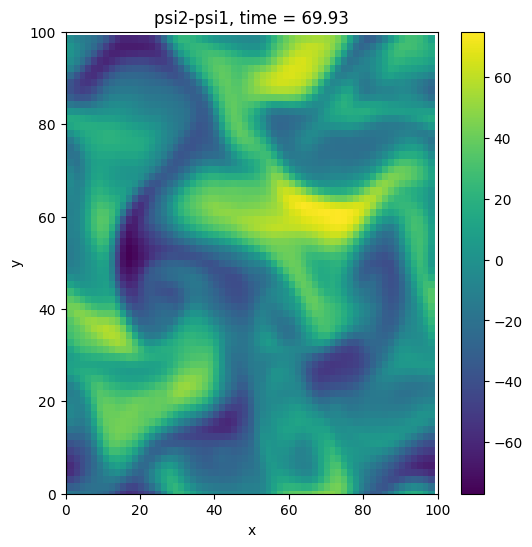

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    streamfunction = plt.pcolor(X, Y, (psi2_save[n,:,:].T-psi1_save[n,:,:].T))
    # Specify the axis limits and labels
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('psi2-psi1, time = {0:.2f}'.format(t_save[n]))
    return (streamfunction,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 1.5 Student investigation
<a id='section1pt5'></a>
In lectures, we found growing solutions of the form

$$ \psi_{1,2}=Re\left[\hat{\psi}_{1,2}e^{ikx+\sigma t}\right], $$

where

$$ \sigma = Uk \left(\frac{2/R_d^2-k^2}{2/R_d^2+k^2}\right)^{1/2}, $$

is the exponential growth rate, $R_d=\sqrt{g'H}/f_0$ is the deformation radius in each layer, and $k$ is the wavenumber in the $x$ direction where $\lambda=2\pi/k$ is the wavelength.

In the box below, compare the result of the simulation with what you would expect based on the growth rate given above. Comment on the possible reasons for any differences. Discuss the behaviour of the flow in the simulation at later times and comment on the relevance to storms in the atmosphere.

INSERT COMMENTS HERE, ~ 1 PARAGRAPH WITH OPTIONAL PLOT(S)

Comparison with Theoretical Growth Rate:

* Initial Growth: In the initial stages of the simulation, you should observe exponential growth of the perturbations, consistent with the theoretical growth rate formula you provided
* Dominant Wavelength: The fastest-growing wavelength (λ) will be the one that maximizes the growth rate (σ). This dominant wavelength is related to the deformation radius (Rd) and can be estimated from the formula. You should observe that the perturbations in the simulation tend to organize into patterns with this dominant wavelength.
* Deviations at Later Times: As the simulation progresses and the perturbations grow larger, you might notice deviations from the theoretical exponential growth. This is due to nonlinear effects becoming more significant. The Jacobian term (J(ψ, q)) in the QG equations represents these nonlinear interactions, which can modify the growth rate and lead to more complex flow patterns.

Possible Reasons for Differences:

* Nonlinearity: As mentioned earlier, the nonlinear terms in the QG equations become important as the perturbations grow, leading to deviations from the linear theory predictions.
* Viscosity: The viscosity term (ν∇^2q) in the equations acts to damp out small-scale features and can affect the growth rate, especially for shorter wavelengths.
* Boundary Conditions: The periodic boundary conditions used in the simulation are an idealization and may not perfectly represent real-world atmospheric conditions.

Behavior at Later Times:

* At later times, the flow in the simulation typically becomes more complex and chaotic due to nonlinear interactions.
* You might observe the formation of coherent structures like eddies or vortices, which interact with each other and the background flow.
* The energy initially concentrated in the dominant wavelength will cascade to other scales, leading to a more turbulent flow.

Relevance to Atmospheric Storms:

* The two-layer QG model, despite its simplifications, captures some essential features of baroclinic instability, which is a key mechanism for the formation of storms in the atmosphere.
* The simulation results demonstrate how initial perturbations can grow rapidly into larger-scale disturbances, similar to the development of storms.
* The interaction between the jet stream (represented by the background flow) and the storms is also evident in the simulation.
* While the model is idealized, it provides insights into the dynamics of atmospheric storm systems and the role of baroclinic instability in their formation and evolution.



## 2. Jet stream and the dimensional QG equations

The configuration in the previous section illustrates baroclinic instability, but the setup is quite idealized. In particular, we assumed that the Coriolis parameter and the initial velocity were constant. In the atmosphere there is are strong winds at the top of the troposphere in a band called the jet stream. The jet stream is several hundred kilometers wide with wind speeds that can exceed 100 miles per hour (roughly 50 m/s). A variable Coriolis parameter is important for constraining the jet dynamics. If we use $f=f_0+\beta y$, then the equations for $q_1$ and $q_2$ become:

$$ \partial_t(q_1) + U_1 \partial_x(q_1) + \partial_x(\psi_1)\left(\beta + \frac{U_1-U_2}{R_{d1}^2}\right)+\nu_4 \nabla^4 q_1 = - J(\psi_1, q_1), $$

$$ \partial_t(q_2) + U_2 \partial_x(q_2) + \partial_x(\psi_2)\left(\beta + \frac{U_2-U_1}{R_{d2}^2}\right)+\nu_4 \nabla^4 q_2 = - J(\psi_2, q_2). $$

Here, we have also switched from a viscous term to a 'hyperviscous' term, where $-\nabla^2 q_{1,2}$ has been replaced by $\nabla^4 q_{1,2}$ where $\nabla^4=(\nabla^2)^2=(\partial^2_x+\partial^2_y)^2$. Using a hyperviscosity is useful because it acts to preferentially damp small scale motions (with large horizontal wavenumbers), while having less influence on the larger scale motions (with small horizontal wavenumbers). It is useful in this case since we would like the jet not to be strongly influenced by viscosity.

We can simulate baroclinic instability on the jet stream by localizing the north/south gradient in the QG potential voriticty in the center of our computational domain. However, since our boundary conditions are periodic, we need the potential vorticity that we solve for to be equal at the northern and southern boundaries. We can accomplish this with the following trick. For our initial condition, let the total potential vorticity in layer 1 be:

$$ q_1 = Q_1 tanh\left(\frac{y-Ly/2}{w}\right) $$

where $Ly$ is the domain size, $Q_1$ is a constant dimensional amplitude and $w$ is the jet width. Clearly $q_1$ isn't periodic in the y-direction. Instead, we can impose a uniform background potential vorticity gradient (as we did in Section 1 above) and solve for the departure from this background gradient. We can then set the amplitude of the background gradient to make the <em>departure</em> from the background gradient periodic. Specifically, the departure from the background potential vorticity gradient will be:

$$ q_1 = Q_1 (tanh\left(\frac{y-Ly/2}{w}\right) - \frac{y-Ly/2}{Ly/2}) $$

which is periodic in $y$ (check for yourself if you aren't sure), and the background potential voricity gradient will be $2Q_1/Ly$ which then ensures that the total PV is the tanh function defined above.

1. Jet Stream and Variable Coriolis Parameter:

* In the previous section, the Coriolis parameter (f) and the initial velocity (U) were assumed to be constant. However, in the real atmosphere, the Coriolis parameter varies with latitude, and there is a strong jet stream with high wind speeds in the upper troposphere.
* To incorporate these effects, the following changes are made:
  * Variable Coriolis Parameter: The Coriolis parameter is now expressed as f = f0 + βy, where β represents the meridional gradient of the Coriolis parameter (beta-plane approximation).
  * Jet Stream: The background flow is modified to include a jet stream, with different velocities in the upper (U1) and lower (U2) layers.

2. New Terms:
* ∂𝑥(𝜓1)(𝛽 + (U1 - U2)/𝑅𝑑1^2), ∂𝑥(𝜓2)(𝛽 + (U2 - U1)/𝑅𝑑2^2): These terms represent the advection of potential vorticity by the jet stream and the variable Coriolis parameter. They capture the interaction between the jet, the Earth's rotation, and the flow dynamics.
* 𝜈4∇^4𝑞1, 𝜈4∇^4𝑞2: These terms represent hyperviscosity, which is a higher-order diffusion term used to preferentially damp out small-scale features while having less influence on the larger-scale jet stream.

3. Impact on Baroclinic Instability:

* The modifications to the equations introduce more realistic dynamics, allowing for a better representation of baroclinic instability in the presence of a jet stream and variable Coriolis parameter.
* The jet stream can influence the growth rate and structure of the unstable waves, leading to more complex and realistic patterns of storm development.
* The variable Coriolis parameter also plays a role in constraining the jet dynamics and the evolution of the instability.

### 2.1 Dedalus script

The script below sets up and solves the 2-layer QG equations in dimensional units (kilometers for x, y and seconds for time). The size of the box is 30,000 km in the x-direction and 10,000 km in the y-direction. This roughly corresponds to the Northern Hemisphere, although it is important to note that the analogy is only approximate since we are still solvin the equations in a Cartesian geometry and not a sphere.

Run the script below and comment on the results and the behavior of the jet stream in the text box below the script. You can also try changing some of the parameters at the top of the script to see how the result change.

Note that the script will likely take a few minutes to run.  Coordinate with the other members of your group so that you can each run a different case.

In [ ]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.1e+01/s


2024-11-26 14:46:11,697 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.1e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.6e+01/s


2024-11-26 14:46:11,844 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 2.6e+01/s


2024-11-26 14:46:12,034 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


2024-11-26 14:46:12,218 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


2024-11-26 14:46:12,422 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


2024-11-26 14:46:12,611 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


2024-11-26 14:46:12,792 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 2.6e+01/s


2024-11-26 14:46:12,975 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.7e+01/s


2024-11-26 14:46:13,158 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


2024-11-26 14:46:13,358 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


2024-11-26 14:46:13,479 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


INFO:__main__:Starting main loop


2024-11-26 14:46:13,580 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2024-11-26 14:46:14,070 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2024-11-26 14:46:14,730 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2024-11-26 14:46:15,369 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2024-11-26 14:46:15,992 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2024-11-26 14:46:16,637 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2024-11-26 14:46:17,272 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2024-11-26 14:46:17,926 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2024-11-26 14:46:18,595 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2024-11-26 14:46:19,434 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2024-11-26 14:46:20,390 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2024-11-26 14:46:21,420 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2024-11-26 14:46:22,412 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2024-11-26 14:46:23,059 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2024-11-26 14:46:23,725 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2024-11-26 14:46:24,372 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2024-11-26 14:46:25,014 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2024-11-26 14:46:25,660 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2024-11-26 14:46:26,321 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2024-11-26 14:46:26,970 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2024-11-26 14:46:27,605 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2024-11-26 14:46:28,249 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2024-11-26 14:46:28,930 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2024-11-26 14:46:29,562 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2024-11-26 14:46:30,220 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2024-11-26 14:46:30,867 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2024-11-26 14:46:31,536 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2024-11-26 14:46:32,176 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2024-11-26 14:46:33,079 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2024-11-26 14:46:34,076 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2024-11-26 14:46:35,095 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2024-11-26 14:46:35,968 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2024-11-26 14:46:36,636 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2024-11-26 14:46:37,298 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2024-11-26 14:46:37,938 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2024-11-26 14:46:38,593 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2024-11-26 14:46:39,219 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2024-11-26 14:46:39,863 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2024-11-26 14:46:40,524 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2024-11-26 14:46:41,159 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2024-11-26 14:46:41,798 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2024-11-26 14:46:42,450 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2024-11-26 14:46:43,072 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2024-11-26 14:46:43,719 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2024-11-26 14:46:44,363 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2024-11-26 14:46:44,995 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2024-11-26 14:46:45,652 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2024-11-26 14:46:46,622 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2024-11-26 14:46:47,579 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2024-11-26 14:46:48,587 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2024-11-26 14:46:49,390 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2024-11-26 14:46:50,015 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2024-11-26 14:46:50,656 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2024-11-26 14:46:51,291 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2024-11-26 14:46:51,931 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2024-11-26 14:46:52,560 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2024-11-26 14:46:53,215 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2024-11-26 14:46:53,870 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2024-11-26 14:46:54,522 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2024-11-26 14:46:55,169 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2024-11-26 14:46:55,806 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2024-11-26 14:46:56,447 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2024-11-26 14:46:57,093 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2024-11-26 14:46:57,730 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2024-11-26 14:46:58,381 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2024-11-26 14:46:59,093 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2024-11-26 14:47:00,065 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2024-11-26 14:47:01,030 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2024-11-26 14:47:02,043 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2024-11-26 14:47:02,820 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2024-11-26 14:47:03,464 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2024-11-26 14:47:04,095 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2024-11-26 14:47:04,734 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2024-11-26 14:47:05,382 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2024-11-26 14:47:05,990 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2024-11-26 14:47:06,633 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2024-11-26 14:47:07,290 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2024-11-26 14:47:07,924 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2024-11-26 14:47:08,573 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2024-11-26 14:47:09,207 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2024-11-26 14:47:09,853 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2024-11-26 14:47:10,488 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2024-11-26 14:47:11,114 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2024-11-26 14:47:11,760 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2024-11-26 14:47:12,398 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2024-11-26 14:47:13,380 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2024-11-26 14:47:14,338 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2024-11-26 14:47:15,372 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2024-11-26 14:47:16,164 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2024-11-26 14:47:16,816 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2024-11-26 14:47:17,465 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2024-11-26 14:47:18,114 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2024-11-26 14:47:18,782 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2024-11-26 14:47:19,525 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2024-11-26 14:47:20,259 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2024-11-26 14:47:20,986 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2024-11-26 14:47:21,692 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2024-11-26 14:47:22,584 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2024-11-26 14:47:23,470 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2024-11-26 14:47:24,303 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2024-11-26 14:47:24,967 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2024-11-26 14:47:25,606 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2024-11-26 14:47:26,516 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2024-11-26 14:47:27,475 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2024-11-26 14:47:28,493 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2024-11-26 14:47:29,426 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2024-11-26 14:47:30,064 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2024-11-26 14:47:30,757 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2024-11-26 14:47:31,449 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2024-11-26 14:47:32,372 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2024-11-26 14:47:33,961 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2024-11-26 14:47:35,180 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2024-11-26 14:47:36,336 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2024-11-26 14:47:37,618 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2024-11-26 14:47:38,275 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2024-11-26 14:47:39,262 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2024-11-26 14:47:40,909 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2024-11-26 14:47:42,806 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2024-11-26 14:47:43,849 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2024-11-26 14:47:44,790 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2024-11-26 14:47:45,462 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2024-11-26 14:47:46,129 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2024-11-26 14:47:46,796 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2024-11-26 14:47:47,478 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2024-11-26 14:47:48,158 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2024-11-26 14:47:48,841 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2024-11-26 14:47:49,526 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2024-11-26 14:47:50,206 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2024-11-26 14:47:50,867 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2024-11-26 14:47:51,517 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2024-11-26 14:47:51,522 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2024-11-26 14:47:51,528 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 2.145 sec


2024-11-26 14:47:51,531 solvers 0/1 INFO :: Setup time (init - iter 0): 2.145 sec


INFO:solvers:Warmup time (iter 0-10): 0.6475 sec


2024-11-26 14:47:51,533 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.6475 sec


INFO:solvers:Run time (iter 10-end): 97.14 sec


2024-11-26 14:47:51,535 solvers 0/1 INFO :: Run time (iter 10-end): 97.14 sec


INFO:solvers:CPU time (iter 10-end): 0.02698 cpu-hr


2024-11-26 14:47:51,538 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02698 cpu-hr


INFO:solvers:Speed: 1.856e+06 mode-stages/cpu-sec


2024-11-26 14:47:51,541 solvers 0/1 INFO :: Speed: 1.856e+06 mode-stages/cpu-sec


### 2.2 Visualization

The script below will visualize the results and create a movie showing the upper layer wind speed (the magnitude of the velocity vector (u1, v1)).

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-11-26 14:49:02,885 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpzj16igf5/temp.m4v


2024-11-26 14:49:02,891 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpzj16igf5/temp.m4v


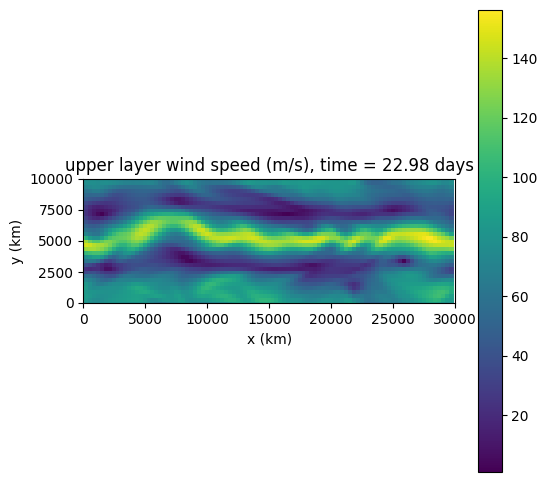

In [ ]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Describe the results in the box below. To what extent are the results qualitatively different from what you saw using the previous script? Comment on the interaction between the jet and the storms. Which features in the simulation do you think occur in the atmosphere? Do you see any features in the simulation that you think are unrealistic? If so, explain why you think those features are unrealistic.

ADD COMMENTS HERE (1-2 PARAGRAPHS). NO NEED FOR PLOTS, BUT YOU CAN INCLUDE THEM IF YOU WANT.

Interpreting the Results and Jet Stream Behavior:

* Jet Stream Meandering: You should observe that the jet stream does not remain straight but instead meanders and develops wave-like patterns. This meandering is a consequence of baroclinic instability, which is the primary focus of the simulation.
* Storm Formation: As the jet stream meanders, it can lead to the formation of storms or eddies. These storms are regions of strong PV gradients and often have a cyclonic (counterclockwise in the Northern Hemisphere) rotation.
* Jet-Storm Interactions: The jet stream and the storms interact with each other, influencing their respective evolution. The storms can extract energy from the jet stream, leading to its further meandering and the formation of more storms.
* Wave Propagation: You might observe the propagation of waves along the jet stream. These waves are called Rossby waves and are a fundamental feature of atmospheric and oceanic dynamics.

Changing Parameters and Exploring:

* The script allows you to change various parameters, such as the deformation radius (Rd), background velocities (U1, U2), beta parameter (β), and hyperviscosity (ν4).
* By changing these parameters, you can explore how they affect the behavior of the jet stream and the development of baroclinic instability.
* For example, increasing the background velocity (U1) might lead to stronger jet stream meandering and more intense storms.

Comparison to the Previous Idealized Case:

* Qualitative Differences: The results are qualitatively different from the previous idealized case, which had a constant Coriolis parameter and background velocity.
* More Realistic Jet Stream: The jet stream in this simulation is more realistic, with meandering and wave-like patterns, similar to what is observed in the real atmosphere.
* Storm Development: The storms in this simulation develop in a more complex and dynamic manner, interacting with the jet stream and each other.
* Wave Propagation: The presence of Rossby waves is a notable difference from the previous case, adding another layer of realism to the simulation.

Interaction between Jet and Storms:

* The interaction between the jet stream and the storms is a key feature of the simulation.
* The storms extract energy from the jet stream, leading to its further meandering and the formation of more storms.
* This interaction is a fundamental mechanism for the transfer of energy and momentum in the atmosphere.

Realistic Features:

* Jet Stream Meandering: The meandering of the jet stream is a well-known phenomenon in the atmosphere and is accurately captured by the simulation.
* Storm Formation: The formation of storms due to baroclinic instability is a fundamental process in the atmosphere and is realistically represented in the simulation.
* Rossby Waves: Rossby waves are ubiquitous in the atmosphere and play a crucial role in weather patterns. Their presence in the simulation adds to its realism.

Unrealistic Features:

* Simplified Geometry: The use of a Cartesian geometry, while computationally convenient, is a simplification. The Earth's curvature and spherical geometry can influence atmospheric flows, especially at larger scales.
* Limited Vertical Structure: The two-layer model is a simplification of the real atmosphere, which has a more complex vertical structure with multiple layers and varying properties.
* Hyperviscosity: While hyperviscosity is a useful numerical technique, it can artificially damp out some smaller-scale features that might be important in real atmospheric flows.

# 3. Forced QG flow

In the atmosphere, differential heating between the equator and poles maintains a north/south temperature gradient. This temperature gradient is represented by the north/south gradient in layer heights and potential vorticity in the 2-layer QG model. We can represent differential heating and cooling in the 2-layer QG model by adding terms that 'relax' the potential vorticity back to a prescribed field.

### 3.1 Student investigation
<a id='section3pt1'></a>

In the code box below, copy the code from Part 2 and modify it to include the following terms:
$$ \frac{\partial q_1}{\partial t} + \ldots = \ldots - \frac{1}{\tau}\left(q_1 - q_1(t=0)\right) $$

$$ \frac{\partial q_2}{\partial t} + \ldots = \ldots - \frac{1}{\tau}\left(q_2 - q_2(t=0)\right) $$

where $q_i(t=0)$ are the initial conditions (q1_ic and q2_ic in the script) and $\tau$ is a timescale which you should specify. A timescale of $\tau=36$ hours should be a good starting point. In the absence of any other terms, this additional forcing term will cause $q_1$ and $q_2$ to 'relax' exponentially back to the initial conditions with an e-folding timescale equal to $\tau$.

Climate change is expected to reduce the equator to pole temperature contrast as the high latitudes warm faster than the rest of the planet. This will have impacts on the intensity and dynamics of storms. Experiment with this by changing the pole to equator gradient in the prescribed initial potential vorticity. Specify which dimensional parameter you chose to vary and discuss how it relates to the north/south temperature gradient. What happens to the jet stream and the storms as you reduce the potential vorticity gradient?

In [ ]:
# Copy and paste the code from section 2.1 here and modify to add the relaxation terms.
# Also, paste the code to visualize the results (or create a new code box below)

# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200

tau = 36*3600 # Timescale for the relaxation term in seconds

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - 1/tau*(q1-q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - 1/tau*(q2-q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.1e+01/s


2024-11-26 14:54:52,263 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.1e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.4e+01/s


2024-11-26 14:54:52,419 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.4e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 2s, Rate: 2.5e+01/s


2024-11-26 14:54:52,615 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 2s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


2024-11-26 14:54:52,795 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


2024-11-26 14:54:52,981 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


2024-11-26 14:54:53,195 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


2024-11-26 14:54:53,395 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


2024-11-26 14:54:53,574 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


2024-11-26 14:54:53,763 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


2024-11-26 14:54:53,961 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


2024-11-26 14:54:54,072 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


INFO:__main__:Starting main loop


2024-11-26 14:54:54,087 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2024-11-26 14:54:54,269 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2024-11-26 14:54:54,981 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2024-11-26 14:54:55,712 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2024-11-26 14:54:56,436 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2024-11-26 14:54:57,121 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2024-11-26 14:54:58,141 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2024-11-26 14:54:59,207 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2024-11-26 14:55:00,355 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2024-11-26 14:55:01,199 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2024-11-26 14:55:01,917 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2024-11-26 14:55:02,632 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2024-11-26 14:55:03,341 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2024-11-26 14:55:04,071 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2024-11-26 14:55:04,801 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2024-11-26 14:55:05,520 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2024-11-26 14:55:06,252 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2024-11-26 14:55:07,018 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2024-11-26 14:55:07,777 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2024-11-26 14:55:08,525 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2024-11-26 14:55:09,252 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2024-11-26 14:55:09,995 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2024-11-26 14:55:10,756 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2024-11-26 14:55:11,838 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2024-11-26 14:55:12,946 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2024-11-26 14:55:14,061 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2024-11-26 14:55:14,812 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2024-11-26 14:55:15,557 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2024-11-26 14:55:16,294 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2024-11-26 14:55:17,015 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2024-11-26 14:55:17,754 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2024-11-26 14:55:18,488 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2024-11-26 14:55:19,216 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2024-11-26 14:55:19,921 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2024-11-26 14:55:20,629 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2024-11-26 14:55:21,355 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2024-11-26 14:55:22,058 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2024-11-26 14:55:22,792 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2024-11-26 14:55:23,513 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2024-11-26 14:55:24,230 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2024-11-26 14:55:25,301 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2024-11-26 14:55:26,365 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2024-11-26 14:55:27,482 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2024-11-26 14:55:28,252 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2024-11-26 14:55:28,974 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2024-11-26 14:55:29,696 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2024-11-26 14:55:30,424 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2024-11-26 14:55:31,136 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2024-11-26 14:55:31,852 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2024-11-26 14:55:32,554 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2024-11-26 14:55:33,274 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2024-11-26 14:55:33,996 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2024-11-26 14:55:34,709 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2024-11-26 14:55:35,441 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2024-11-26 14:55:36,162 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2024-11-26 14:55:36,891 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2024-11-26 14:55:37,607 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2024-11-26 14:55:38,649 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2024-11-26 14:55:39,727 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2024-11-26 14:55:40,848 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2024-11-26 14:55:41,667 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2024-11-26 14:55:42,394 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2024-11-26 14:55:43,153 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2024-11-26 14:55:44,921 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2024-11-26 14:55:45,979 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2024-11-26 14:55:46,946 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2024-11-26 14:55:47,676 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2024-11-26 14:55:48,410 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2024-11-26 14:55:49,112 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2024-11-26 14:55:49,841 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2024-11-26 14:55:50,570 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2024-11-26 14:55:51,373 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2024-11-26 14:55:52,461 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2024-11-26 14:55:53,579 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2024-11-26 14:55:54,693 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2024-11-26 14:55:55,427 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2024-11-26 14:55:56,631 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2024-11-26 14:55:57,927 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2024-11-26 14:55:58,695 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2024-11-26 14:55:59,407 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2024-11-26 14:56:00,171 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2024-11-26 14:56:00,921 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2024-11-26 14:56:01,660 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2024-11-26 14:56:02,403 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2024-11-26 14:56:03,133 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2024-11-26 14:56:03,874 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2024-11-26 14:56:04,605 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2024-11-26 14:56:05,688 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2024-11-26 14:56:06,764 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2024-11-26 14:56:07,894 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2024-11-26 14:56:08,646 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2024-11-26 14:56:09,377 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2024-11-26 14:56:10,103 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2024-11-26 14:56:10,808 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2024-11-26 14:56:11,545 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2024-11-26 14:56:12,280 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2024-11-26 14:56:12,985 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2024-11-26 14:56:13,708 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2024-11-26 14:56:14,445 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2024-11-26 14:56:15,166 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2024-11-26 14:56:15,902 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2024-11-26 14:56:16,624 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2024-11-26 14:56:17,357 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2024-11-26 14:56:18,212 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2024-11-26 14:56:19,284 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2024-11-26 14:56:20,417 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2024-11-26 14:56:21,367 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2024-11-26 14:56:22,095 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2024-11-26 14:56:23,087 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2024-11-26 14:56:23,819 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2024-11-26 14:56:24,537 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2024-11-26 14:56:25,289 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2024-11-26 14:56:26,041 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2024-11-26 14:56:26,786 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2024-11-26 14:56:27,510 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2024-11-26 14:56:28,241 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2024-11-26 14:56:28,975 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2024-11-26 14:56:29,690 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2024-11-26 14:56:30,455 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2024-11-26 14:56:31,284 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2024-11-26 14:56:32,395 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2024-11-26 14:56:33,917 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2024-11-26 14:56:36,020 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2024-11-26 14:56:37,660 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2024-11-26 14:56:38,489 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2024-11-26 14:56:39,220 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2024-11-26 14:56:39,945 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2024-11-26 14:56:40,679 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2024-11-26 14:56:41,413 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2024-11-26 14:56:42,096 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2024-11-26 14:56:42,100 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2024-11-26 14:56:42,104 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.94 sec


2024-11-26 14:56:42,107 solvers 0/1 INFO :: Setup time (init - iter 0): 1.94 sec


INFO:solvers:Warmup time (iter 0-10): 0.5139 sec


2024-11-26 14:56:42,109 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.5139 sec


INFO:solvers:Run time (iter 10-end): 107.5 sec


2024-11-26 14:56:42,111 solvers 0/1 INFO :: Run time (iter 10-end): 107.5 sec


INFO:solvers:CPU time (iter 10-end): 0.02986 cpu-hr


2024-11-26 14:56:42,113 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02986 cpu-hr


INFO:solvers:Speed: 1.677e+06 mode-stages/cpu-sec


2024-11-26 14:56:42,115 solvers 0/1 INFO :: Speed: 1.677e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-11-26 14:57:34,629 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpcndw8g3s/temp.m4v


2024-11-26 14:57:34,633 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpcndw8g3s/temp.m4v


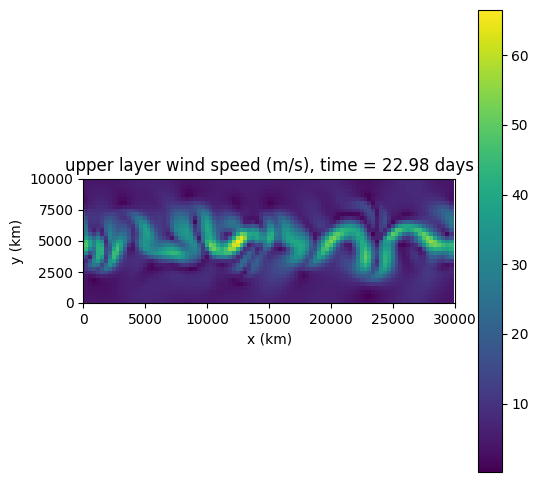

In [ ]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

2. Investigating Climate Change Effects:

To investigate the impact of climate change on the jet stream and storms, we need to change the pole-to-equator gradient in the prescribed initial potential vorticity. This gradient represents the north-south temperature contrast, which is expected to decrease due to climate change.

Dimensional Parameter to Vary:

The dimensional parameter that we can vary to represent the reduced temperature contrast is Q1, the constant dimensional amplitude in the initial PV profile (q1_ic)

Relationship to North-South Temperature Gradient:

* Q1 controls the strength of the PV gradient, which is directly related to the north-south temperature gradient.
* A larger Q1 corresponds to a stronger temperature contrast, while a smaller Q1 represents a weaker contrast.

Experiment and Observations:

* Reducing Q1: By reducing the value of Q1, we can simulate the effect of climate change on the jet stream and storms.
* Jet Stream: As Q1 is reduced, the jet stream is expected to become less meandering and more zonal (flowing primarily in the east-west direction).
* Storms: The storms are expected to become weaker and less frequent as the temperature contrast decreases.

In [ ]:
# Copy and paste the code from section 2.1 here and modify to add the relaxation terms.
# Also, paste the code to visualize the results (or create a new code box below)

# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200

tau = 36*3600 # Timescale for the relaxation term in seconds

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2)) / 2
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - 1/tau*(q1-q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - 1/tau*(q2-q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 1.8e+01/s


2024-11-26 14:59:11,538 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 1.8e+01/s


2024-11-26 14:59:11,766 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 1.8e+01/s


2024-11-26 14:59:12,049 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


2024-11-26 14:59:12,344 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


2024-11-26 14:59:12,643 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 1.8e+01/s


2024-11-26 14:59:12,890 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 1.9e+01/s


2024-11-26 14:59:13,080 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 1.9e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 2.0e+01/s


2024-11-26 14:59:13,275 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 2.0e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.0e+01/s


2024-11-26 14:59:13,468 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.0e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.1e+01/s


2024-11-26 14:59:13,648 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.1e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.1e+01/s


2024-11-26 14:59:13,769 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.1e+01/s


INFO:__main__:Starting main loop


2024-11-26 14:59:13,781 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2024-11-26 14:59:13,949 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2024-11-26 14:59:14,661 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2024-11-26 14:59:15,366 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2024-11-26 14:59:16,066 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2024-11-26 14:59:16,774 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2024-11-26 14:59:17,494 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2024-11-26 14:59:18,190 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2024-11-26 14:59:18,905 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2024-11-26 14:59:19,622 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2024-11-26 14:59:20,307 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2024-11-26 14:59:21,004 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2024-11-26 14:59:21,716 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2024-11-26 14:59:22,420 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2024-11-26 14:59:23,270 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2024-11-26 14:59:24,332 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2024-11-26 14:59:26,412 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2024-11-26 14:59:27,666 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2024-11-26 14:59:28,653 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2024-11-26 14:59:29,360 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2024-11-26 14:59:30,074 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2024-11-26 14:59:30,821 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2024-11-26 14:59:31,552 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2024-11-26 14:59:32,265 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2024-11-26 14:59:32,981 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2024-11-26 14:59:33,686 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2024-11-26 14:59:34,395 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2024-11-26 14:59:35,096 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2024-11-26 14:59:35,820 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2024-11-26 14:59:36,547 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2024-11-26 14:59:37,612 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2024-11-26 14:59:38,666 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2024-11-26 14:59:39,786 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2024-11-26 14:59:40,568 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2024-11-26 14:59:41,266 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2024-11-26 14:59:41,961 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2024-11-26 14:59:42,677 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2024-11-26 14:59:43,381 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2024-11-26 14:59:44,072 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2024-11-26 14:59:44,796 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2024-11-26 14:59:45,496 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2024-11-26 14:59:46,193 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2024-11-26 14:59:46,906 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2024-11-26 14:59:47,621 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2024-11-26 14:59:48,335 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2024-11-26 14:59:49,041 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2024-11-26 14:59:49,746 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2024-11-26 14:59:50,685 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2024-11-26 14:59:51,748 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2024-11-26 14:59:52,906 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2024-11-26 14:59:53,825 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2024-11-26 14:59:54,554 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2024-11-26 14:59:55,277 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2024-11-26 14:59:55,993 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2024-11-26 14:59:56,700 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2024-11-26 14:59:57,414 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2024-11-26 14:59:58,137 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2024-11-26 14:59:58,866 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2024-11-26 14:59:59,582 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2024-11-26 15:00:00,320 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2024-11-26 15:00:01,076 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2024-11-26 15:00:01,785 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2024-11-26 15:00:02,500 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2024-11-26 15:00:03,237 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2024-11-26 15:00:04,262 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2024-11-26 15:00:05,354 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2024-11-26 15:00:06,514 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2024-11-26 15:00:07,293 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2024-11-26 15:00:08,025 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2024-11-26 15:00:08,744 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2024-11-26 15:00:09,465 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2024-11-26 15:00:10,159 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2024-11-26 15:00:10,877 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2024-11-26 15:00:11,615 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2024-11-26 15:00:12,335 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2024-11-26 15:00:13,059 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2024-11-26 15:00:13,788 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2024-11-26 15:00:14,518 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2024-11-26 15:00:15,240 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2024-11-26 15:00:15,976 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2024-11-26 15:00:16,739 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2024-11-26 15:00:17,842 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2024-11-26 15:00:18,925 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2024-11-26 15:00:20,008 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2024-11-26 15:00:20,715 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2024-11-26 15:00:21,417 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2024-11-26 15:00:22,120 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2024-11-26 15:00:22,815 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2024-11-26 15:00:23,533 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2024-11-26 15:00:24,241 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2024-11-26 15:00:24,937 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2024-11-26 15:00:25,656 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2024-11-26 15:00:26,377 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2024-11-26 15:00:27,090 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2024-11-26 15:00:27,795 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2024-11-26 15:00:28,531 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2024-11-26 15:00:29,241 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2024-11-26 15:00:29,962 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2024-11-26 15:00:31,057 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2024-11-26 15:00:32,131 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2024-11-26 15:00:33,243 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2024-11-26 15:00:34,028 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2024-11-26 15:00:34,744 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2024-11-26 15:00:35,463 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2024-11-26 15:00:36,158 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2024-11-26 15:00:36,871 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2024-11-26 15:00:37,597 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2024-11-26 15:00:38,367 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2024-11-26 15:00:39,331 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2024-11-26 15:00:40,048 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2024-11-26 15:00:40,773 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2024-11-26 15:00:41,467 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2024-11-26 15:00:42,170 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2024-11-26 15:00:42,876 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2024-11-26 15:00:43,660 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2024-11-26 15:00:44,731 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2024-11-26 15:00:45,815 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2024-11-26 15:00:46,914 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2024-11-26 15:00:47,615 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2024-11-26 15:00:48,322 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2024-11-26 15:00:49,011 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2024-11-26 15:00:49,706 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2024-11-26 15:00:50,430 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2024-11-26 15:00:51,137 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2024-11-26 15:00:51,859 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2024-11-26 15:00:52,570 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2024-11-26 15:00:53,272 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2024-11-26 15:00:53,984 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2024-11-26 15:00:54,700 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2024-11-26 15:00:55,366 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2024-11-26 15:00:55,375 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2024-11-26 15:00:55,378 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 2.403 sec


2024-11-26 15:00:55,381 solvers 0/1 INFO :: Setup time (init - iter 0): 2.403 sec


INFO:solvers:Warmup time (iter 0-10): 0.4873 sec


2024-11-26 15:00:55,383 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4873 sec


INFO:solvers:Run time (iter 10-end): 101.1 sec


2024-11-26 15:00:55,391 solvers 0/1 INFO :: Run time (iter 10-end): 101.1 sec


INFO:solvers:CPU time (iter 10-end): 0.02808 cpu-hr


2024-11-26 15:00:55,393 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02808 cpu-hr


INFO:solvers:Speed: 1.783e+06 mode-stages/cpu-sec


2024-11-26 15:00:55,395 solvers 0/1 INFO :: Speed: 1.783e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-11-26 15:05:12,164 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpd5ojzrom/temp.m4v


2024-11-26 15:05:12,171 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpd5ojzrom/temp.m4v


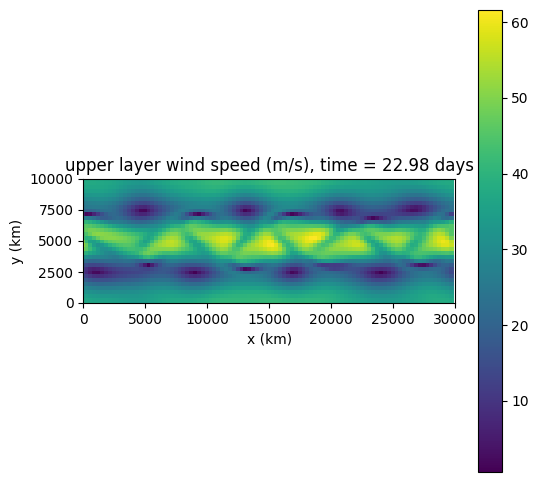

In [ ]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())